In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
!pip install scipy==1.2.1
import os
import argparse
import warnings
import numpy as np
import matplotlib.pyplot as plt
import json
warnings.filterwarnings("ignore")

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# to the directory of workspace_4471
import sys
sys.path.append('/content/drive/MyDrive/workspace_4471')
sys.path.append('/workspace_4471') # for other packages import

In [16]:
# Local imports
from data_loader import get_image_loader
from models_v2 import CycleGenerator_v2, DCDiscriminator
from cycle_utils import create_dir, create_model, checkpoint, save_samples

In [17]:
SEED = 11
# Set the random seed manually for reproducibility.
np.random.seed(SEED)
torch.manual_seed(SEED)

In [18]:
class Opts():
    def __init__(self):
        self.image_size = 256
        self.g_conv_dim = 32
        self.init_zero_weights = True # Choose whether to initialize the generator conv weights to 0 (implements the identity function)

        # Training hyper-parameters
        # self.train_iters = 100000 NEED MODIFY !!!!!!!!!!
        self.train_iters = 15000 # ONLY TESTING !!!!!!!!!!
        self.batch_size = 1
        self.num_workers = 1
        self.lr = 5e-5 # original 2e-4
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.lbd_cyclegan = 10
        self.lbd_identity = 10

        self.X = 'day' #Choose the type of images for domain X
        self.Y = 'night' #Choose the type of images for domain Y.

        # Saving directories and checkpoint/sample iterations
        self.checkpoint_dir = 'drive/MyDrive/workspace_4471/checkpoints_cyclegan_w_idloss'
        self.sample_dir = 'drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss'
        self.log_step = 10
        self.sample_every = 400
        self.checkpoint_every = 1600
        self.losslog_dir = 'drive/MyDrive/workspace_4471/losslog_dir_w_idloss'
        
    
def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


In [19]:
opts = Opts()
print_opts(opts)

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 256                                    
                             g_conv_dim: 32                                     
                      init_zero_weights: 1                                      
                            train_iters: 15000                                  
                             batch_size: 1                                      
                            num_workers: 1                                      
                                     lr: 5e-05                                  
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                           lbd_cyclegan: 10                                     
                           l

In [20]:
def load_checkpoint(G_XtoY, G_YtoX, D_X, D_Y, g_optimizer, d_optimizer, iter, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        G_XtoY.load_state_dict(checkpoint['G_XtoY'])
        G_YtoX.load_state_dict(checkpoint['G_YtoX'])
        D_X.load_state_dict(checkpoint['D_X'])
        D_Y.load_state_dict(checkpoint['D_Y'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer'])
        iter = checkpoint['iter']
        
        print("=> loaded checkpoint '{}' (iter {})"
                  .format(filename, checkpoint['iter']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))
        iter = 0

    return G_XtoY, G_YtoX, D_X, D_Y, g_optimizer, d_optimizer, iter

In [21]:
"""
Loads the data, creates checkpoint and sample directories, and starts the training loop.
"""

# Create train and test dataloaders for images from the two domains X and Y
dataloader_X, test_dataloader_X = get_image_loader(img_type=opts.X, opts=opts )
dataloader_Y, test_dataloader_Y = get_image_loader(img_type=opts.Y, opts=opts )

# Create checkpoint and sample directories
create_dir(opts.checkpoint_dir)
create_dir(opts.sample_dir)
create_dir(opts.losslog_dir)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

len(dataloader_X), len(dataloader_Y)

(1626, 1626)

In [22]:
# Create generators and discriminators
G_XtoY, G_YtoX, D_X, D_Y = create_model(opts)
G_XtoY.to(device)
G_YtoX.to(device)
D_X.to(device)
D_Y.to(device)

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters
d_params = list(D_X.parameters()) + list(D_Y.parameters())  # Get discriminator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
d_optimizer = optim.Adam(d_params, opts.lr, [opts.beta1, opts.beta2])


In [23]:
curr_iter = 0 # remember to reset to 0 when "restart and runall"
ckpt_filepath = os.path.join(opts.checkpoint_dir, 'ckpt_{:06d}.pth.tar'.format(curr_iter))
load_checkpoint(G_XtoY, G_YtoX, D_X, D_Y, g_optimizer, d_optimizer, curr_iter, ckpt_filepath)

iter_X = iter(dataloader_X)
iter_Y = iter(dataloader_Y)

test_iter_X = iter(test_dataloader_X)
test_iter_Y = iter(test_dataloader_Y)

# Get some fixed data from domains X and Y for sampling. These are images that are held
# constant throughout training, that allow us to inspect the model's performance.
fixed_X = test_iter_X.next()[0].to(device)
fixed_Y = test_iter_Y.next()[0].to(device)

#len(iter_X), len(iter_Y) # 203, 203
#fixed_X.shape # torch.Size([8, 3, 512, 512])

=> no checkpoint found at 'drive/MyDrive/workspace_4471/checkpoints_cyclegan_w_idloss/ckpt_000000.pth.tar'


Iteration [   10/15000] | d_real_loss: 0.3335 | d_Y_real_loss: 0.1454 | d_X_real_loss: 0.1881 | d_Y_fake_loss: 0.2065 | d_X_fake_loss: 0.2168 |  d_fake_loss: 0.4234 | g_loss_XYX: 4.0522 | g_loss_YXY: 12.0119
Iteration [   20/15000] | d_real_loss: 0.2491 | d_Y_real_loss: 0.0869 | d_X_real_loss: 0.1622 | d_Y_fake_loss: 0.1882 | d_X_fake_loss: 0.1975 |  d_fake_loss: 0.3857 | g_loss_XYX: 3.9864 | g_loss_YXY: 12.9270
Iteration [   30/15000] | d_real_loss: 0.3493 | d_Y_real_loss: 0.1992 | d_X_real_loss: 0.1501 | d_Y_fake_loss: 0.1725 | d_X_fake_loss: 0.2464 |  d_fake_loss: 0.4189 | g_loss_XYX: 3.9608 | g_loss_YXY: 8.2236
Iteration [   40/15000] | d_real_loss: 0.2881 | d_Y_real_loss: 0.1543 | d_X_real_loss: 0.1338 | d_Y_fake_loss: 0.1694 | d_X_fake_loss: 0.2511 |  d_fake_loss: 0.4206 | g_loss_XYX: 2.6918 | g_loss_YXY: 10.8331
Iteration [   50/15000] | d_real_loss: 0.2332 | d_Y_real_loss: 0.0794 | d_X_real_loss: 0.1539 | d_Y_fake_loss: 0.1504 | d_X_fake_loss: 0.1885 |  d_fake_loss: 0.3389 | g_

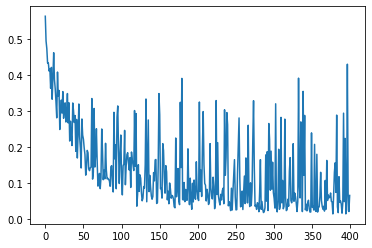

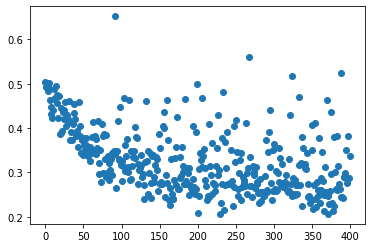

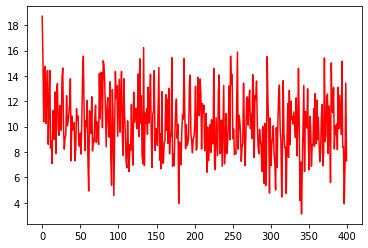

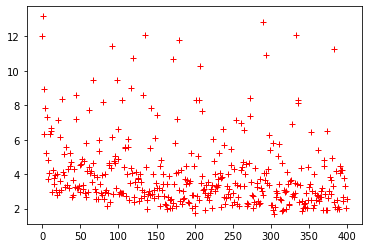

Iteration [  400/15000] | d_real_loss: 0.0654 | d_Y_real_loss: 0.0105 | d_X_real_loss: 0.0549 | d_Y_fake_loss: 0.1472 | d_X_fake_loss: 0.1903 |  d_fake_loss: 0.3374 | g_loss_XYX: 2.5279 | g_loss_YXY: 7.2899
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-000400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-000400-Y-X.png
Iteration [  410/15000] | d_real_loss: 0.0157 | d_Y_real_loss: 0.0034 | d_X_real_loss: 0.0123 | d_Y_fake_loss: 0.1251 | d_X_fake_loss: 0.1453 |  d_fake_loss: 0.2704 | g_loss_XYX: 2.1627 | g_loss_YXY: 15.5409
Iteration [  420/15000] | d_real_loss: 0.0694 | d_Y_real_loss: 0.0055 | d_X_real_loss: 0.0639 | d_Y_fake_loss: 0.1242 | d_X_fake_loss: 0.1360 |  d_fake_loss: 0.2602 | g_loss_XYX: 5.0152 | g_loss_YXY: 9.0683
Iteration [  430/15000] | d_real_loss: 0.0378 | d_Y_real_loss: 0.0038 | d_X_real_loss: 0.0339 | d_Y_fake_loss: 0.1170 | d_X_fake_loss: 0.1745 |  d_fake_loss: 0.2914 | g_loss_XYX: 4.0308 | g_loss_YXY: 9.5489
Itera

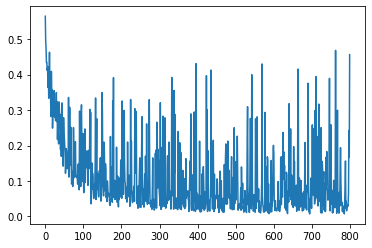

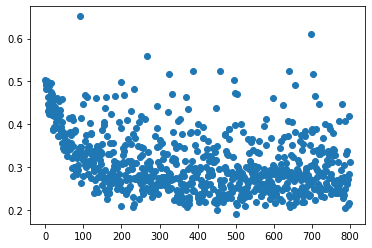

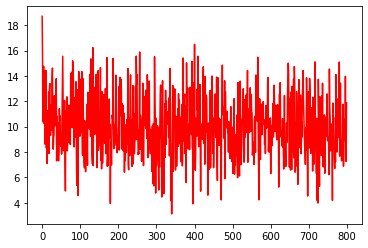

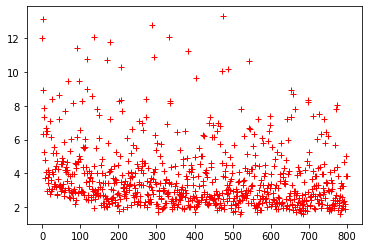

Iteration [  800/15000] | d_real_loss: 0.4563 | d_Y_real_loss: 0.0016 | d_X_real_loss: 0.4547 | d_Y_fake_loss: 0.1541 | d_X_fake_loss: 0.1574 |  d_fake_loss: 0.3114 | g_loss_XYX: 3.8275 | g_loss_YXY: 11.8831
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-000800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-000800-Y-X.png
Iteration [  810/15000] | d_real_loss: 0.0185 | d_Y_real_loss: 0.0063 | d_X_real_loss: 0.0121 | d_Y_fake_loss: 0.1119 | d_X_fake_loss: 0.1467 |  d_fake_loss: 0.2585 | g_loss_XYX: 2.0345 | g_loss_YXY: 13.1147
Iteration [  820/15000] | d_real_loss: 0.1201 | d_Y_real_loss: 0.0166 | d_X_real_loss: 0.1035 | d_Y_fake_loss: 0.1277 | d_X_fake_loss: 0.1396 |  d_fake_loss: 0.2674 | g_loss_XYX: 10.4125 | g_loss_YXY: 10.8219
Iteration [  830/15000] | d_real_loss: 0.0162 | d_Y_real_loss: 0.0029 | d_X_real_loss: 0.0132 | d_Y_fake_loss: 0.1047 | d_X_fake_loss: 0.2482 |  d_fake_loss: 0.3529 | g_loss_XYX: 2.1090 | g_loss_YXY: 13.1895
I

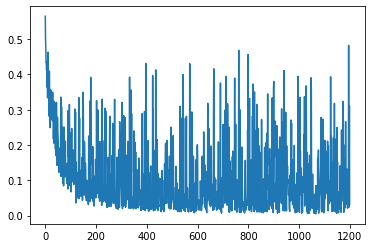

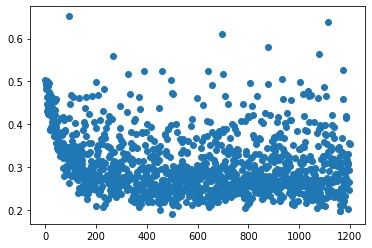

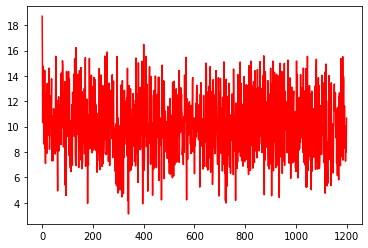

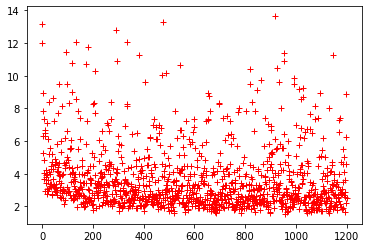

Iteration [ 1200/15000] | d_real_loss: 0.0320 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.0311 | d_Y_fake_loss: 0.1091 | d_X_fake_loss: 0.2452 |  d_fake_loss: 0.3543 | g_loss_XYX: 2.5008 | g_loss_YXY: 10.6686
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-001200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-001200-Y-X.png
Iteration [ 1210/15000] | d_real_loss: 0.1959 | d_Y_real_loss: 0.0300 | d_X_real_loss: 0.1659 | d_Y_fake_loss: 0.1161 | d_X_fake_loss: 0.1174 |  d_fake_loss: 0.2335 | g_loss_XYX: 2.4555 | g_loss_YXY: 5.0913
Iteration [ 1220/15000] | d_real_loss: 0.0847 | d_Y_real_loss: 0.0010 | d_X_real_loss: 0.0837 | d_Y_fake_loss: 0.1041 | d_X_fake_loss: 0.1202 |  d_fake_loss: 0.2243 | g_loss_XYX: 1.9649 | g_loss_YXY: 6.7820
Iteration [ 1230/15000] | d_real_loss: 0.0053 | d_Y_real_loss: 0.0009 | d_X_real_loss: 0.0044 | d_Y_fake_loss: 0.1078 | d_X_fake_loss: 0.1778 |  d_fake_loss: 0.2856 | g_loss_XYX: 1.3720 | g_loss_YXY: 9.4276
Itera

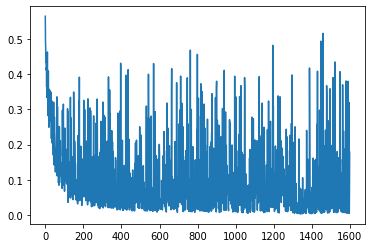

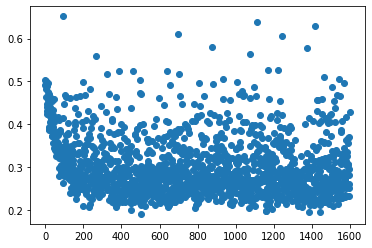

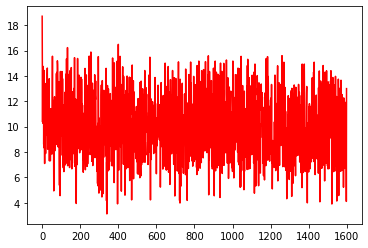

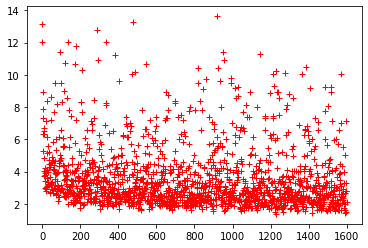

Iteration [ 1600/15000] | d_real_loss: 0.1780 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.1771 | d_Y_fake_loss: 0.1187 | d_X_fake_loss: 0.3100 |  d_fake_loss: 0.4287 | g_loss_XYX: 2.1325 | g_loss_YXY: 12.9961
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-001600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-001600-Y-X.png
Iteration [ 1610/15000] | d_real_loss: 0.0037 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0032 | d_Y_fake_loss: 0.1083 | d_X_fake_loss: 0.3339 |  d_fake_loss: 0.4421 | g_loss_XYX: 1.7971 | g_loss_YXY: 13.1195
Iteration [ 1620/15000] | d_real_loss: 0.0560 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.0552 | d_Y_fake_loss: 0.1099 | d_X_fake_loss: 0.2308 |  d_fake_loss: 0.3407 | g_loss_XYX: 2.2996 | g_loss_YXY: 7.8287
Iteration [ 1630/15000] | d_real_loss: 0.0524 | d_Y_real_loss: 0.0246 | d_X_real_loss: 0.0278 | d_Y_fake_loss: 0.1165 | d_X_fake_loss: 0.1629 |  d_fake_loss: 0.2794 | g_loss_XYX: 2.0208 | g_loss_YXY: 10.7832
Ite

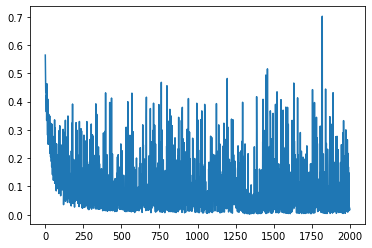

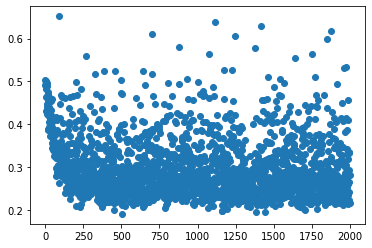

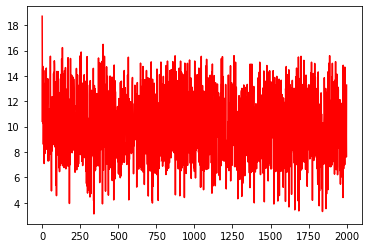

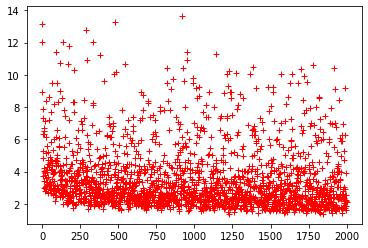

Iteration [ 2000/15000] | d_real_loss: 0.0194 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.0186 | d_Y_fake_loss: 0.1197 | d_X_fake_loss: 0.1629 |  d_fake_loss: 0.2826 | g_loss_XYX: 2.1083 | g_loss_YXY: 13.2762
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002000-Y-X.png
Iteration [ 2010/15000] | d_real_loss: 0.0450 | d_Y_real_loss: 0.0028 | d_X_real_loss: 0.0422 | d_Y_fake_loss: 0.1150 | d_X_fake_loss: 0.1014 |  d_fake_loss: 0.2164 | g_loss_XYX: 3.8594 | g_loss_YXY: 9.0268
Iteration [ 2020/15000] | d_real_loss: 0.1020 | d_Y_real_loss: 0.0148 | d_X_real_loss: 0.0871 | d_Y_fake_loss: 0.1157 | d_X_fake_loss: 0.1087 |  d_fake_loss: 0.2244 | g_loss_XYX: 4.1498 | g_loss_YXY: 5.6418
Iteration [ 2030/15000] | d_real_loss: 0.1236 | d_Y_real_loss: 0.0013 | d_X_real_loss: 0.1223 | d_Y_fake_loss: 0.1144 | d_X_fake_loss: 0.2233 |  d_fake_loss: 0.3378 | g_loss_XYX: 1.9613 | g_loss_YXY: 11.9633
Iter

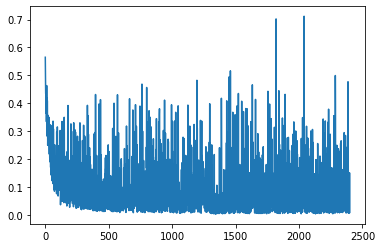

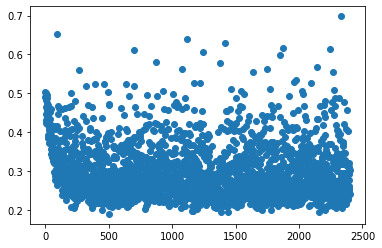

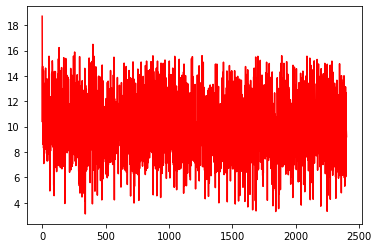

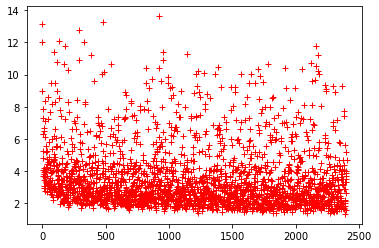

Iteration [ 2400/15000] | d_real_loss: 0.0084 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0077 | d_Y_fake_loss: 0.1172 | d_X_fake_loss: 0.1852 |  d_fake_loss: 0.3024 | g_loss_XYX: 4.7105 | g_loss_YXY: 9.2079
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002400-Y-X.png
Iteration [ 2410/15000] | d_real_loss: 0.0594 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0589 | d_Y_fake_loss: 0.1176 | d_X_fake_loss: 0.1670 |  d_fake_loss: 0.2846 | g_loss_XYX: 1.6989 | g_loss_YXY: 13.1990
Iteration [ 2420/15000] | d_real_loss: 0.1209 | d_Y_real_loss: 0.0011 | d_X_real_loss: 0.1198 | d_Y_fake_loss: 0.1203 | d_X_fake_loss: 0.1933 |  d_fake_loss: 0.3136 | g_loss_XYX: 1.5684 | g_loss_YXY: 9.9497
Iteration [ 2430/15000] | d_real_loss: 0.1608 | d_Y_real_loss: 0.0011 | d_X_real_loss: 0.1597 | d_Y_fake_loss: 0.1085 | d_X_fake_loss: 0.1980 |  d_fake_loss: 0.3065 | g_loss_XYX: 1.8529 | g_loss_YXY: 9.4282
Itera

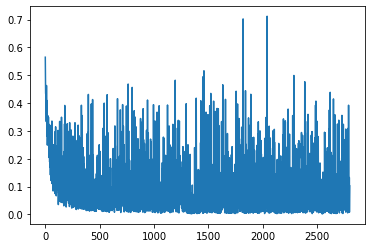

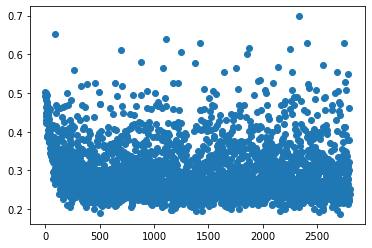

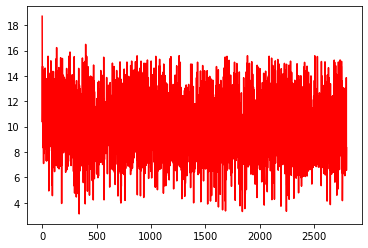

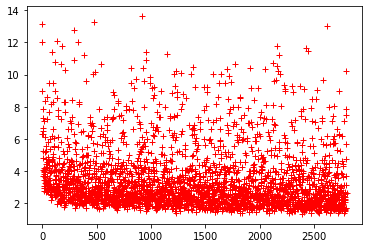

Iteration [ 2800/15000] | d_real_loss: 0.1028 | d_Y_real_loss: 0.0010 | d_X_real_loss: 0.1017 | d_Y_fake_loss: 0.1229 | d_X_fake_loss: 0.1284 |  d_fake_loss: 0.2512 | g_loss_XYX: 2.6539 | g_loss_YXY: 8.3358
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-002800-Y-X.png
Iteration [ 2810/15000] | d_real_loss: 0.0708 | d_Y_real_loss: 0.0021 | d_X_real_loss: 0.0687 | d_Y_fake_loss: 0.1159 | d_X_fake_loss: 0.1639 |  d_fake_loss: 0.2798 | g_loss_XYX: 3.0312 | g_loss_YXY: 7.2728
Iteration [ 2820/15000] | d_real_loss: 0.0265 | d_Y_real_loss: 0.0112 | d_X_real_loss: 0.0153 | d_Y_fake_loss: 0.1238 | d_X_fake_loss: 0.1665 |  d_fake_loss: 0.2903 | g_loss_XYX: 4.3461 | g_loss_YXY: 5.8119
Iteration [ 2830/15000] | d_real_loss: 0.0230 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.0222 | d_Y_fake_loss: 0.1167 | d_X_fake_loss: 0.1117 |  d_fake_loss: 0.2284 | g_loss_XYX: 6.5173 | g_loss_YXY: 9.4017
Iterat

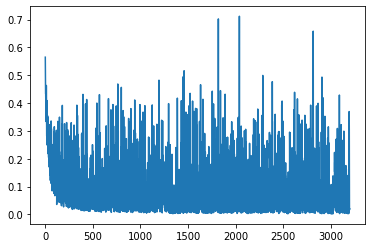

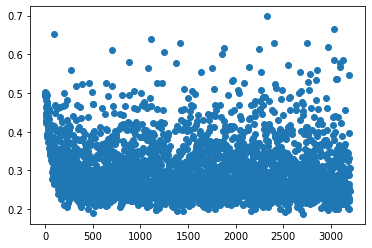

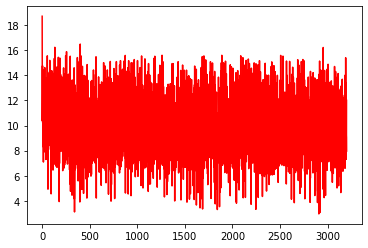

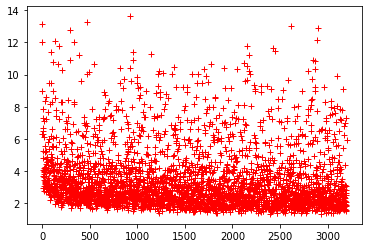

Iteration [ 3200/15000] | d_real_loss: 0.0178 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.0170 | d_Y_fake_loss: 0.1148 | d_X_fake_loss: 0.1905 |  d_fake_loss: 0.3054 | g_loss_XYX: 5.9115 | g_loss_YXY: 12.0062
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-003200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-003200-Y-X.png
Iteration [ 3210/15000] | d_real_loss: 0.0099 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0095 | d_Y_fake_loss: 0.1154 | d_X_fake_loss: 0.1605 |  d_fake_loss: 0.2759 | g_loss_XYX: 1.5194 | g_loss_YXY: 10.7293
Iteration [ 3220/15000] | d_real_loss: 0.1037 | d_Y_real_loss: 0.0022 | d_X_real_loss: 0.1015 | d_Y_fake_loss: 0.1195 | d_X_fake_loss: 0.1355 |  d_fake_loss: 0.2550 | g_loss_XYX: 1.7259 | g_loss_YXY: 12.3200
Iteration [ 3230/15000] | d_real_loss: 0.1520 | d_Y_real_loss: 0.0014 | d_X_real_loss: 0.1506 | d_Y_fake_loss: 0.1173 | d_X_fake_loss: 0.1824 |  d_fake_loss: 0.2997 | g_loss_XYX: 3.7429 | g_loss_YXY: 7.7477
Ite

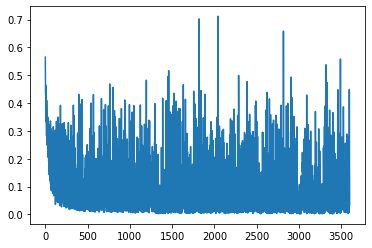

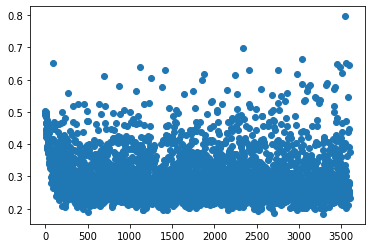

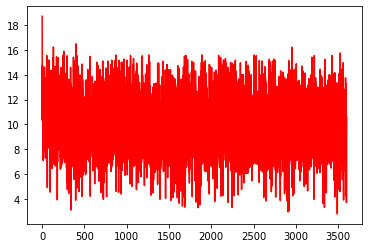

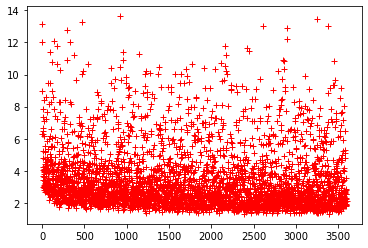

Iteration [ 3600/15000] | d_real_loss: 0.0325 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0322 | d_Y_fake_loss: 0.1086 | d_X_fake_loss: 0.2672 |  d_fake_loss: 0.3758 | g_loss_XYX: 2.1267 | g_loss_YXY: 10.5612
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-003600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-003600-Y-X.png
Iteration [ 3610/15000] | d_real_loss: 0.0566 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0563 | d_Y_fake_loss: 0.1155 | d_X_fake_loss: 0.2053 |  d_fake_loss: 0.3207 | g_loss_XYX: 1.9017 | g_loss_YXY: 11.4609
Iteration [ 3620/15000] | d_real_loss: 0.0737 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0733 | d_Y_fake_loss: 0.1092 | d_X_fake_loss: 0.1398 |  d_fake_loss: 0.2490 | g_loss_XYX: 2.8046 | g_loss_YXY: 9.0671
Iteration [ 3630/15000] | d_real_loss: 0.1407 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.1403 | d_Y_fake_loss: 0.1191 | d_X_fake_loss: 0.3825 |  d_fake_loss: 0.5016 | g_loss_XYX: 2.4356 | g_loss_YXY: 14.2151
Ite

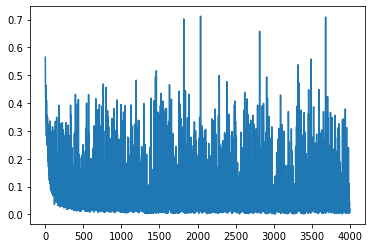

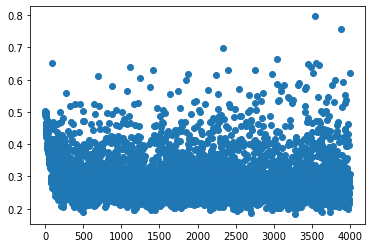

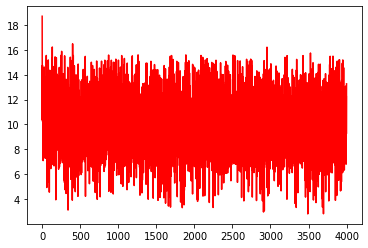

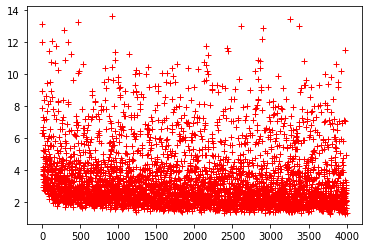

Iteration [ 4000/15000] | d_real_loss: 0.0185 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0182 | d_Y_fake_loss: 0.1163 | d_X_fake_loss: 0.5038 |  d_fake_loss: 0.6201 | g_loss_XYX: 1.3302 | g_loss_YXY: 13.2660
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004000-Y-X.png
Iteration [ 4010/15000] | d_real_loss: 0.0097 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0093 | d_Y_fake_loss: 0.1119 | d_X_fake_loss: 0.2321 |  d_fake_loss: 0.3440 | g_loss_XYX: 1.9049 | g_loss_YXY: 12.3614
Iteration [ 4020/15000] | d_real_loss: 0.1383 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.1380 | d_Y_fake_loss: 0.1179 | d_X_fake_loss: 0.1640 |  d_fake_loss: 0.2819 | g_loss_XYX: 2.0358 | g_loss_YXY: 13.1055
Iteration [ 4030/15000] | d_real_loss: 0.2609 | d_Y_real_loss: 0.0032 | d_X_real_loss: 0.2577 | d_Y_fake_loss: 0.1066 | d_X_fake_loss: 0.1456 |  d_fake_loss: 0.2522 | g_loss_XYX: 4.1650 | g_loss_YXY: 9.1172
Ite

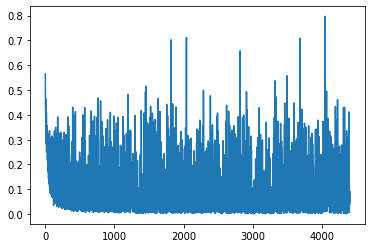

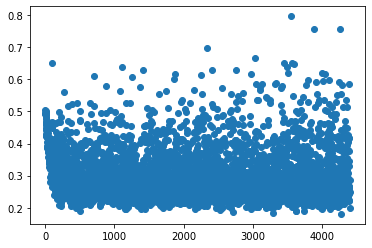

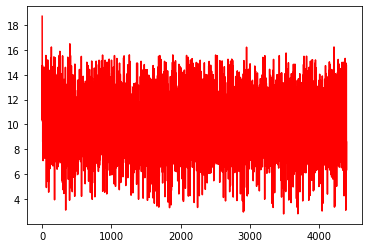

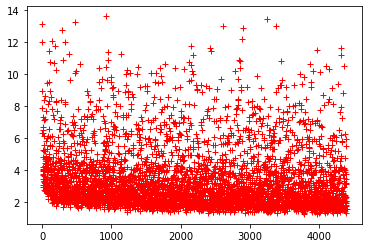

Iteration [ 4400/15000] | d_real_loss: 0.0388 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0382 | d_Y_fake_loss: 0.1247 | d_X_fake_loss: 0.1623 |  d_fake_loss: 0.2870 | g_loss_XYX: 1.5493 | g_loss_YXY: 8.5823
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004400-Y-X.png
Iteration [ 4410/15000] | d_real_loss: 0.0378 | d_Y_real_loss: 0.0033 | d_X_real_loss: 0.0345 | d_Y_fake_loss: 0.1165 | d_X_fake_loss: 0.1554 |  d_fake_loss: 0.2719 | g_loss_XYX: 3.0665 | g_loss_YXY: 5.9731
Iteration [ 4420/15000] | d_real_loss: 0.0083 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0080 | d_Y_fake_loss: 0.1277 | d_X_fake_loss: 0.1868 |  d_fake_loss: 0.3145 | g_loss_XYX: 9.1541 | g_loss_YXY: 9.6872
Iteration [ 4430/15000] | d_real_loss: 0.0377 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0373 | d_Y_fake_loss: 0.1143 | d_X_fake_loss: 0.2030 |  d_fake_loss: 0.3174 | g_loss_XYX: 6.8470 | g_loss_YXY: 10.4785
Itera

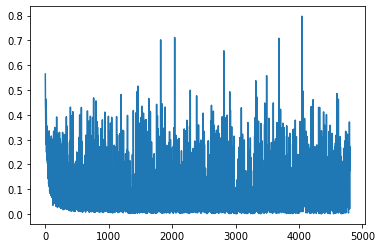

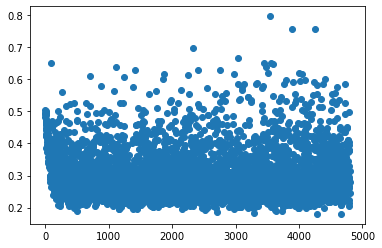

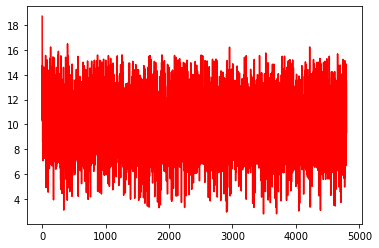

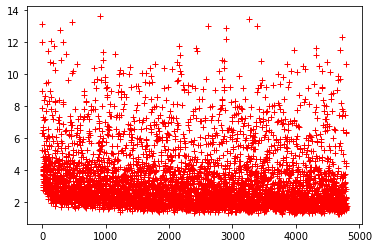

Iteration [ 4800/15000] | d_real_loss: 0.1752 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.1747 | d_Y_fake_loss: 0.1217 | d_X_fake_loss: 0.1921 |  d_fake_loss: 0.3138 | g_loss_XYX: 1.7451 | g_loss_YXY: 9.3921
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-004800-Y-X.png
Iteration [ 4810/15000] | d_real_loss: 0.0627 | d_Y_real_loss: 0.0007 | d_X_real_loss: 0.0620 | d_Y_fake_loss: 0.1318 | d_X_fake_loss: 0.2305 |  d_fake_loss: 0.3623 | g_loss_XYX: 2.1168 | g_loss_YXY: 11.9562
Iteration [ 4820/15000] | d_real_loss: 0.0480 | d_Y_real_loss: 0.0013 | d_X_real_loss: 0.0468 | d_Y_fake_loss: 0.1146 | d_X_fake_loss: 0.1273 |  d_fake_loss: 0.2419 | g_loss_XYX: 3.1622 | g_loss_YXY: 8.7463
Iteration [ 4830/15000] | d_real_loss: 0.2964 | d_Y_real_loss: 0.0065 | d_X_real_loss: 0.2899 | d_Y_fake_loss: 0.1213 | d_X_fake_loss: 0.1005 |  d_fake_loss: 0.2218 | g_loss_XYX: 3.1026 | g_loss_YXY: 12.6145
Iter

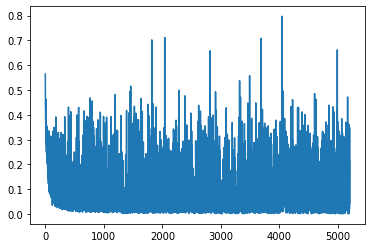

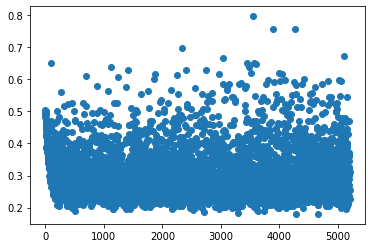

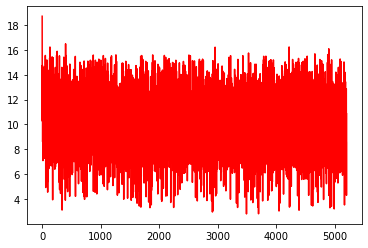

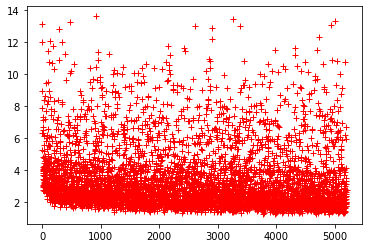

Iteration [ 5200/15000] | d_real_loss: 0.0229 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0227 | d_Y_fake_loss: 0.1253 | d_X_fake_loss: 0.1026 |  d_fake_loss: 0.2278 | g_loss_XYX: 2.7650 | g_loss_YXY: 10.8604
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-005200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-005200-Y-X.png
Iteration [ 5210/15000] | d_real_loss: 0.2502 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.2498 | d_Y_fake_loss: 0.1106 | d_X_fake_loss: 0.1444 |  d_fake_loss: 0.2550 | g_loss_XYX: 1.5968 | g_loss_YXY: 9.5705
Iteration [ 5220/15000] | d_real_loss: 0.2446 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.2440 | d_Y_fake_loss: 0.1271 | d_X_fake_loss: 0.2057 |  d_fake_loss: 0.3328 | g_loss_XYX: 2.0970 | g_loss_YXY: 7.8685
Iteration [ 5230/15000] | d_real_loss: 0.0213 | d_Y_real_loss: 0.0095 | d_X_real_loss: 0.0118 | d_Y_fake_loss: 0.1130 | d_X_fake_loss: 0.1591 |  d_fake_loss: 0.2721 | g_loss_XYX: 2.9180 | g_loss_YXY: 6.9313
Itera

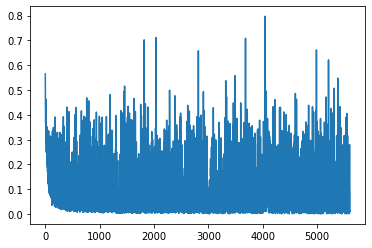

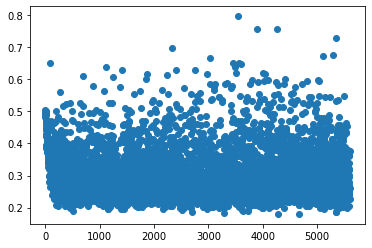

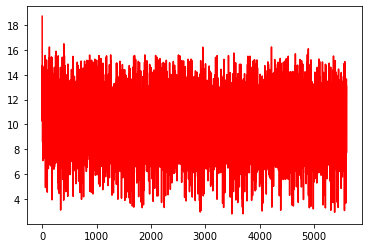

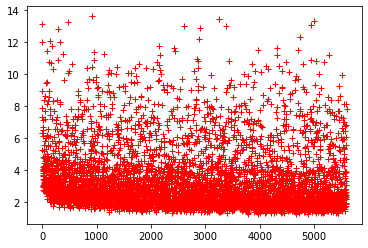

Iteration [ 5600/15000] | d_real_loss: 0.0116 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0113 | d_Y_fake_loss: 0.1204 | d_X_fake_loss: 0.2552 |  d_fake_loss: 0.3757 | g_loss_XYX: 7.8049 | g_loss_YXY: 13.0672
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-005600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-005600-Y-X.png
Iteration [ 5610/15000] | d_real_loss: 0.0553 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.0548 | d_Y_fake_loss: 0.1108 | d_X_fake_loss: 0.1377 |  d_fake_loss: 0.2485 | g_loss_XYX: 4.1972 | g_loss_YXY: 12.2876
Iteration [ 5620/15000] | d_real_loss: 0.0250 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0248 | d_Y_fake_loss: 0.1190 | d_X_fake_loss: 0.2177 |  d_fake_loss: 0.3368 | g_loss_XYX: 3.7742 | g_loss_YXY: 11.8548
Iteration [ 5630/15000] | d_real_loss: 0.3301 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.3299 | d_Y_fake_loss: 0.1133 | d_X_fake_loss: 0.2020 |  d_fake_loss: 0.3154 | g_loss_XYX: 1.5899 | g_loss_YXY: 8.9313
Ite

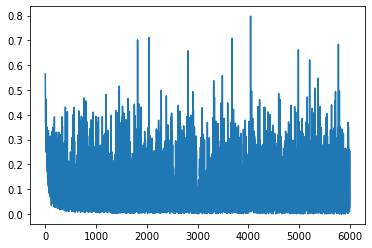

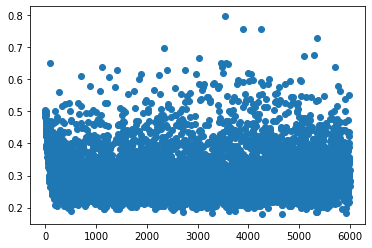

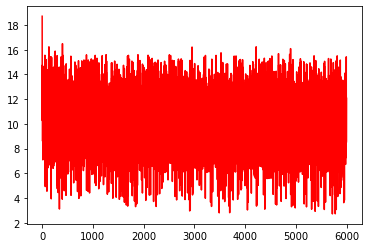

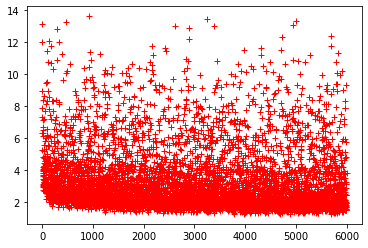

Iteration [ 6000/15000] | d_real_loss: 0.0116 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0114 | d_Y_fake_loss: 0.1177 | d_X_fake_loss: 0.1638 |  d_fake_loss: 0.2814 | g_loss_XYX: 3.7802 | g_loss_YXY: 12.0688
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006000-Y-X.png
Iteration [ 6010/15000] | d_real_loss: 0.1518 | d_Y_real_loss: 0.0008 | d_X_real_loss: 0.1509 | d_Y_fake_loss: 0.1164 | d_X_fake_loss: 0.1198 |  d_fake_loss: 0.2362 | g_loss_XYX: 1.8961 | g_loss_YXY: 4.7077
Iteration [ 6020/15000] | d_real_loss: 0.0969 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0967 | d_Y_fake_loss: 0.1123 | d_X_fake_loss: 0.3945 |  d_fake_loss: 0.5067 | g_loss_XYX: 2.0364 | g_loss_YXY: 8.7704
Iteration [ 6030/15000] | d_real_loss: 0.1036 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1034 | d_Y_fake_loss: 0.1274 | d_X_fake_loss: 0.1598 |  d_fake_loss: 0.2872 | g_loss_XYX: 2.8546 | g_loss_YXY: 6.6919
Itera

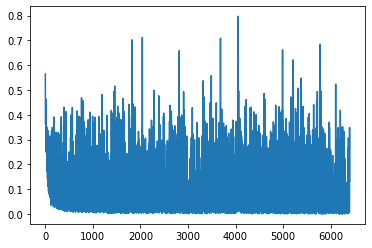

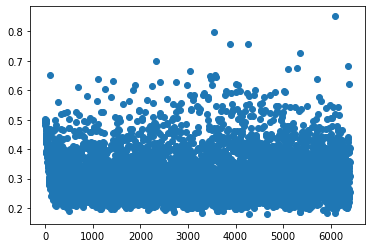

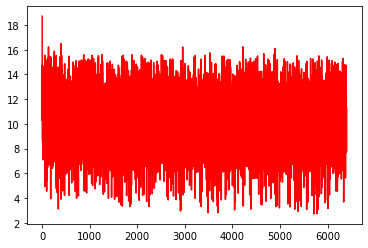

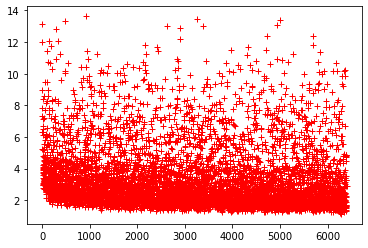

Iteration [ 6400/15000] | d_real_loss: 0.1312 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1310 | d_Y_fake_loss: 0.1169 | d_X_fake_loss: 0.2877 |  d_fake_loss: 0.4046 | g_loss_XYX: 2.8858 | g_loss_YXY: 11.1951
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006400-Y-X.png
Iteration [ 6410/15000] | d_real_loss: 0.1569 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1567 | d_Y_fake_loss: 0.1153 | d_X_fake_loss: 0.2500 |  d_fake_loss: 0.3653 | g_loss_XYX: 2.3258 | g_loss_YXY: 9.1267
Iteration [ 6420/15000] | d_real_loss: 0.1918 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1916 | d_Y_fake_loss: 0.1182 | d_X_fake_loss: 0.1248 |  d_fake_loss: 0.2429 | g_loss_XYX: 1.4989 | g_loss_YXY: 9.2534
Iteration [ 6430/15000] | d_real_loss: 0.1627 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.1624 | d_Y_fake_loss: 0.1188 | d_X_fake_loss: 0.2647 |  d_fake_loss: 0.3834 | g_loss_XYX: 2.3288 | g_loss_YXY: 10.4940
Iter

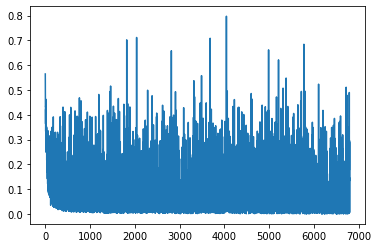

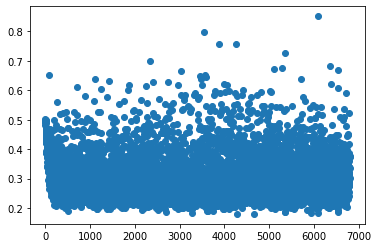

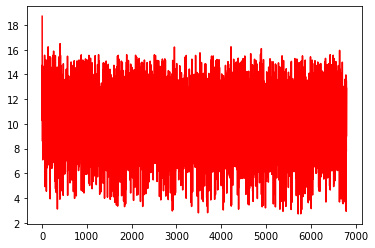

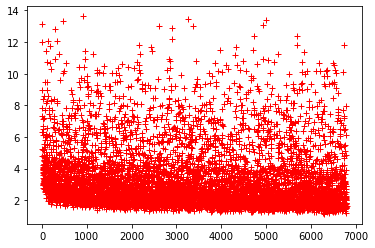

Iteration [ 6800/15000] | d_real_loss: 0.1443 | d_Y_real_loss: 0.0048 | d_X_real_loss: 0.1394 | d_Y_fake_loss: 0.1155 | d_X_fake_loss: 0.2611 |  d_fake_loss: 0.3766 | g_loss_XYX: 1.6592 | g_loss_YXY: 12.8658
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-006800-Y-X.png
Iteration [ 6810/15000] | d_real_loss: 0.1652 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.1645 | d_Y_fake_loss: 0.1167 | d_X_fake_loss: 0.2506 |  d_fake_loss: 0.3673 | g_loss_XYX: 1.5071 | g_loss_YXY: 7.0740
Iteration [ 6820/15000] | d_real_loss: 0.1871 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1869 | d_Y_fake_loss: 0.1301 | d_X_fake_loss: 0.2634 |  d_fake_loss: 0.3935 | g_loss_XYX: 1.7207 | g_loss_YXY: 8.5605
Iteration [ 6830/15000] | d_real_loss: 0.0819 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0817 | d_Y_fake_loss: 0.1173 | d_X_fake_loss: 0.3080 |  d_fake_loss: 0.4252 | g_loss_XYX: 1.3867 | g_loss_YXY: 11.5243
Iter

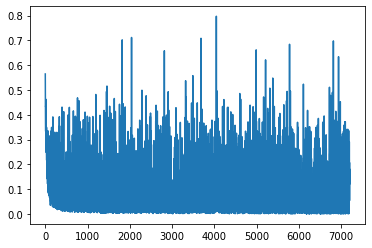

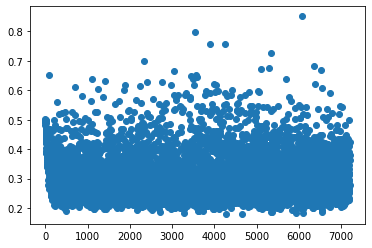

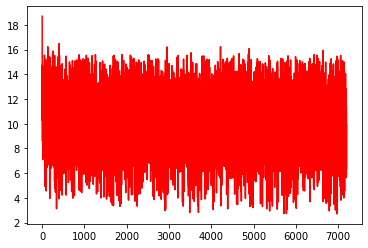

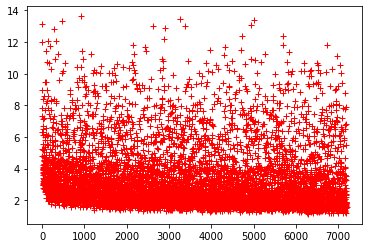

Iteration [ 7200/15000] | d_real_loss: 0.1217 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1215 | d_Y_fake_loss: 0.1208 | d_X_fake_loss: 0.2414 |  d_fake_loss: 0.3623 | g_loss_XYX: 1.5508 | g_loss_YXY: 9.9197
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-007200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-007200-Y-X.png
Iteration [ 7210/15000] | d_real_loss: 0.0131 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0128 | d_Y_fake_loss: 0.1172 | d_X_fake_loss: 0.1747 |  d_fake_loss: 0.2919 | g_loss_XYX: 8.4178 | g_loss_YXY: 10.0990
Iteration [ 7220/15000] | d_real_loss: 0.0664 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0658 | d_Y_fake_loss: 0.1111 | d_X_fake_loss: 0.1388 |  d_fake_loss: 0.2499 | g_loss_XYX: 5.2232 | g_loss_YXY: 6.5024
Iteration [ 7230/15000] | d_real_loss: 0.2024 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.2018 | d_Y_fake_loss: 0.1134 | d_X_fake_loss: 0.1591 |  d_fake_loss: 0.2725 | g_loss_XYX: 2.0151 | g_loss_YXY: 8.3351
Itera

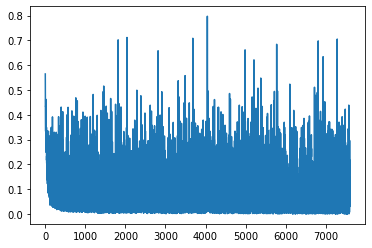

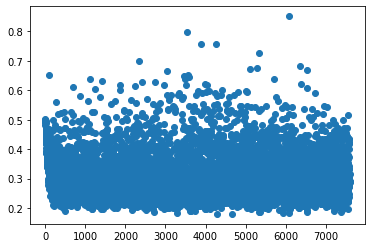

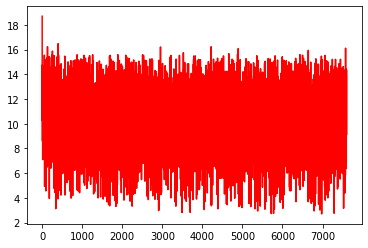

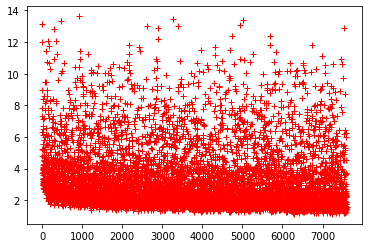

Iteration [ 7600/15000] | d_real_loss: 0.0846 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0844 | d_Y_fake_loss: 0.1061 | d_X_fake_loss: 0.2107 |  d_fake_loss: 0.3168 | g_loss_XYX: 1.5641 | g_loss_YXY: 14.2837
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-007600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-007600-Y-X.png
Iteration [ 7610/15000] | d_real_loss: 0.0830 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0828 | d_Y_fake_loss: 0.1155 | d_X_fake_loss: 0.2689 |  d_fake_loss: 0.3844 | g_loss_XYX: 1.6390 | g_loss_YXY: 9.9483
Iteration [ 7620/15000] | d_real_loss: 0.0862 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0861 | d_Y_fake_loss: 0.2077 | d_X_fake_loss: 0.1782 |  d_fake_loss: 0.3859 | g_loss_XYX: 2.3662 | g_loss_YXY: 12.6529
Iteration [ 7630/15000] | d_real_loss: 0.1981 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.1976 | d_Y_fake_loss: 0.1248 | d_X_fake_loss: 0.1560 |  d_fake_loss: 0.2808 | g_loss_XYX: 1.7431 | g_loss_YXY: 10.4160
Ite

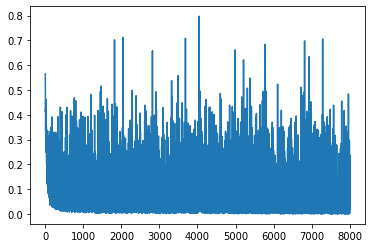

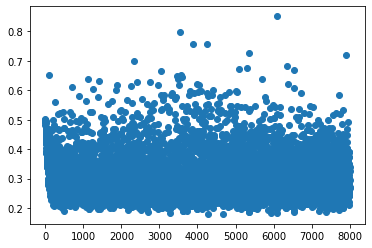

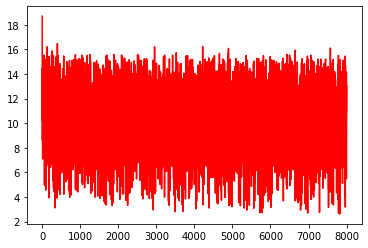

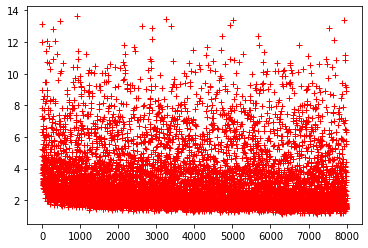

Iteration [ 8000/15000] | d_real_loss: 0.1520 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1519 | d_Y_fake_loss: 0.1141 | d_X_fake_loss: 0.1820 |  d_fake_loss: 0.2961 | g_loss_XYX: 2.1451 | g_loss_YXY: 10.9349
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008000-Y-X.png
Iteration [ 8010/15000] | d_real_loss: 0.3064 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.3063 | d_Y_fake_loss: 0.1139 | d_X_fake_loss: 0.1796 |  d_fake_loss: 0.2935 | g_loss_XYX: 1.8666 | g_loss_YXY: 7.6227
Iteration [ 8020/15000] | d_real_loss: 0.0078 | d_Y_real_loss: 0.0035 | d_X_real_loss: 0.0043 | d_Y_fake_loss: 0.1088 | d_X_fake_loss: 0.0935 |  d_fake_loss: 0.2023 | g_loss_XYX: 3.9096 | g_loss_YXY: 5.6578
Iteration [ 8030/15000] | d_real_loss: 0.1924 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1923 | d_Y_fake_loss: 0.1132 | d_X_fake_loss: 0.1890 |  d_fake_loss: 0.3022 | g_loss_XYX: 1.1956 | g_loss_YXY: 10.6309
Iter

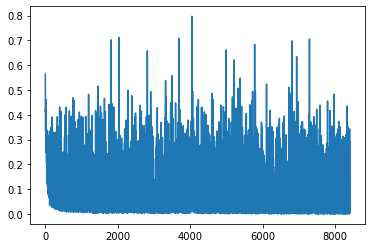

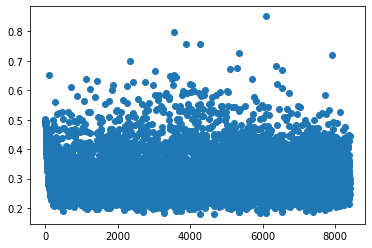

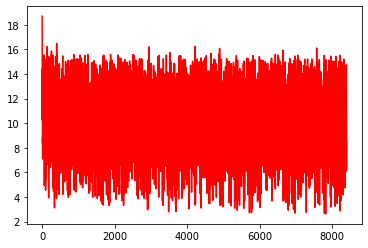

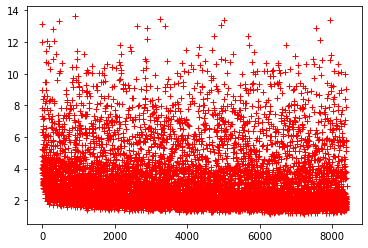

Iteration [ 8400/15000] | d_real_loss: 0.0583 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0581 | d_Y_fake_loss: 0.1252 | d_X_fake_loss: 0.1608 |  d_fake_loss: 0.2860 | g_loss_XYX: 2.8689 | g_loss_YXY: 8.5518
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008400-Y-X.png
Iteration [ 8410/15000] | d_real_loss: 0.1216 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1215 | d_Y_fake_loss: 0.1184 | d_X_fake_loss: 0.4420 |  d_fake_loss: 0.5604 | g_loss_XYX: 2.0994 | g_loss_YXY: 10.7157
Iteration [ 8420/15000] | d_real_loss: 0.2832 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.2831 | d_Y_fake_loss: 0.1181 | d_X_fake_loss: 0.2933 |  d_fake_loss: 0.4114 | g_loss_XYX: 3.0118 | g_loss_YXY: 10.6060
Iteration [ 8430/15000] | d_real_loss: 0.0320 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0319 | d_Y_fake_loss: 0.1106 | d_X_fake_loss: 0.1658 |  d_fake_loss: 0.2764 | g_loss_XYX: 3.8945 | g_loss_YXY: 16.0492
Ite

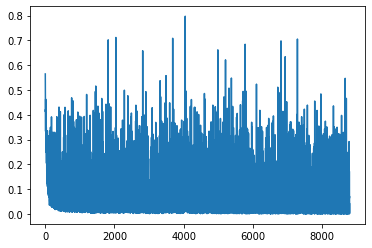

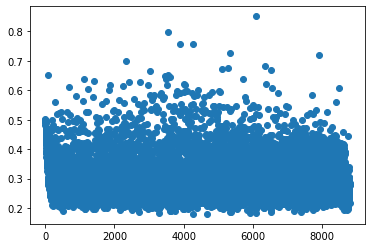

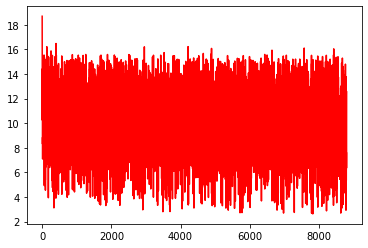

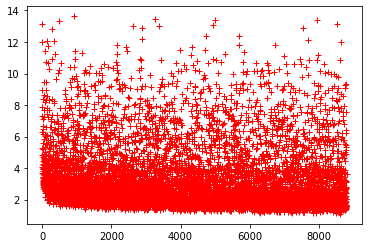

Iteration [ 8800/15000] | d_real_loss: 0.0407 | d_Y_real_loss: 0.0011 | d_X_real_loss: 0.0395 | d_Y_fake_loss: 0.1358 | d_X_fake_loss: 0.1429 |  d_fake_loss: 0.2787 | g_loss_XYX: 3.6064 | g_loss_YXY: 7.5813
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-008800-Y-X.png
Iteration [ 8810/15000] | d_real_loss: 0.0055 | d_Y_real_loss: 0.0010 | d_X_real_loss: 0.0045 | d_Y_fake_loss: 0.1165 | d_X_fake_loss: 0.1217 |  d_fake_loss: 0.2382 | g_loss_XYX: 1.5728 | g_loss_YXY: 6.4661
Iteration [ 8820/15000] | d_real_loss: 0.0196 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0194 | d_Y_fake_loss: 0.1005 | d_X_fake_loss: 0.1217 |  d_fake_loss: 0.2222 | g_loss_XYX: 5.4076 | g_loss_YXY: 9.2886
Iteration [ 8830/15000] | d_real_loss: 0.0067 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0066 | d_Y_fake_loss: 0.0981 | d_X_fake_loss: 0.1770 |  d_fake_loss: 0.2751 | g_loss_XYX: 3.0218 | g_loss_YXY: 11.1009
Itera

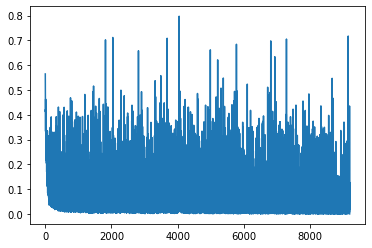

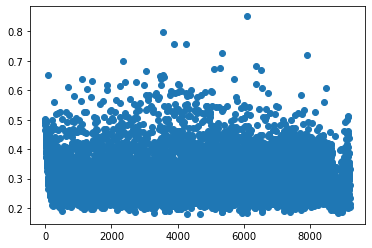

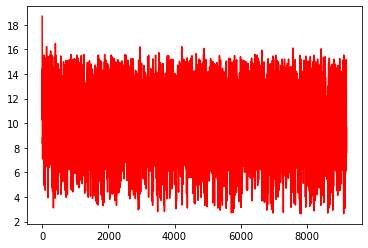

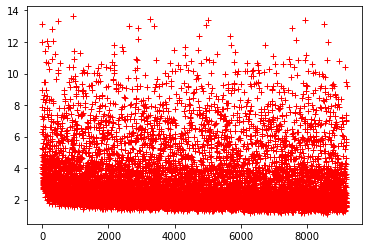

Iteration [ 9200/15000] | d_real_loss: 0.0003 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0001 | d_Y_fake_loss: 0.1176 | d_X_fake_loss: 0.1596 |  d_fake_loss: 0.2771 | g_loss_XYX: 9.2157 | g_loss_YXY: 9.6805
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-009200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-009200-Y-X.png
Iteration [ 9210/15000] | d_real_loss: 0.1651 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1650 | d_Y_fake_loss: 0.1210 | d_X_fake_loss: 0.3511 |  d_fake_loss: 0.4721 | g_loss_XYX: 1.5697 | g_loss_YXY: 11.8434
Iteration [ 9220/15000] | d_real_loss: 0.0007 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0005 | d_Y_fake_loss: 0.1094 | d_X_fake_loss: 0.1940 |  d_fake_loss: 0.3034 | g_loss_XYX: 7.6303 | g_loss_YXY: 8.9950
Iteration [ 9230/15000] | d_real_loss: 0.2707 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.2706 | d_Y_fake_loss: 0.1113 | d_X_fake_loss: 0.3148 |  d_fake_loss: 0.4260 | g_loss_XYX: 2.0177 | g_loss_YXY: 8.8481
Itera

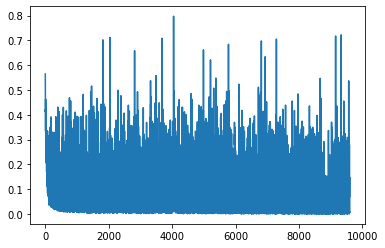

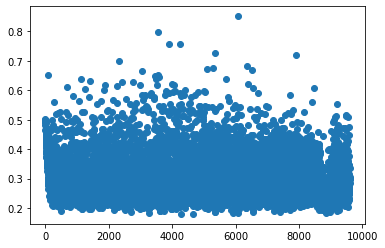

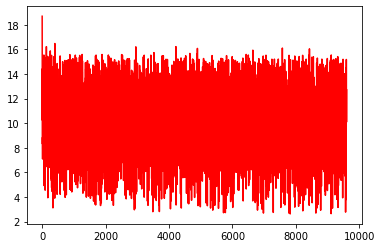

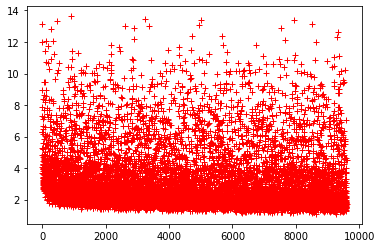

Iteration [ 9600/15000] | d_real_loss: 0.0094 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0092 | d_Y_fake_loss: 0.1087 | d_X_fake_loss: 0.1916 |  d_fake_loss: 0.3003 | g_loss_XYX: 4.5266 | g_loss_YXY: 10.1564
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-009600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-009600-Y-X.png
Iteration [ 9610/15000] | d_real_loss: 0.0491 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0488 | d_Y_fake_loss: 0.1128 | d_X_fake_loss: 0.0891 |  d_fake_loss: 0.2019 | g_loss_XYX: 1.8934 | g_loss_YXY: 5.4329
Iteration [ 9620/15000] | d_real_loss: 0.0183 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0182 | d_Y_fake_loss: 0.1169 | d_X_fake_loss: 0.2470 |  d_fake_loss: 0.3639 | g_loss_XYX: 2.1348 | g_loss_YXY: 11.4180
Iteration [ 9630/15000] | d_real_loss: 0.0130 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0128 | d_Y_fake_loss: 0.1082 | d_X_fake_loss: 0.1083 |  d_fake_loss: 0.2165 | g_loss_XYX: 7.2615 | g_loss_YXY: 7.6646
Iter

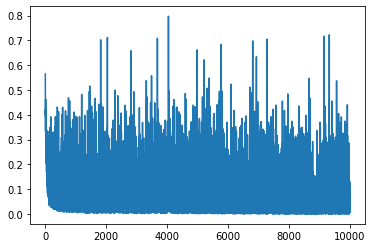

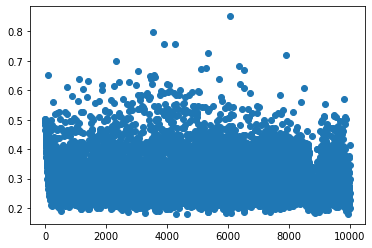

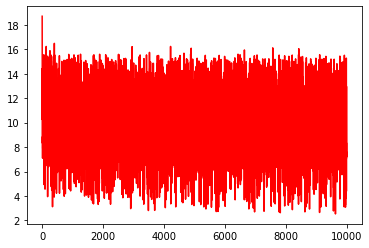

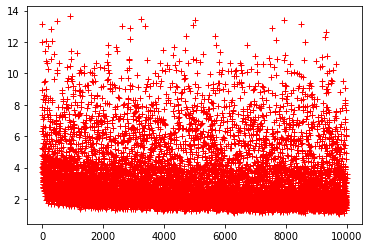

Iteration [10000/15000] | d_real_loss: 0.0061 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0060 | d_Y_fake_loss: 0.1132 | d_X_fake_loss: 0.1858 |  d_fake_loss: 0.2990 | g_loss_XYX: 3.3167 | g_loss_YXY: 8.2910
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010000-Y-X.png
Iteration [10010/15000] | d_real_loss: 0.0475 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0473 | d_Y_fake_loss: 0.0997 | d_X_fake_loss: 0.2381 |  d_fake_loss: 0.3377 | g_loss_XYX: 3.5520 | g_loss_YXY: 13.7702
Iteration [10020/15000] | d_real_loss: 0.0005 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0004 | d_Y_fake_loss: 0.1126 | d_X_fake_loss: 0.2005 |  d_fake_loss: 0.3131 | g_loss_XYX: 5.0260 | g_loss_YXY: 11.4503
Iteration [10030/15000] | d_real_loss: 0.0123 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0122 | d_Y_fake_loss: 0.1117 | d_X_fake_loss: 0.1529 |  d_fake_loss: 0.2645 | g_loss_XYX: 2.4798 | g_loss_YXY: 11.1069
Ite

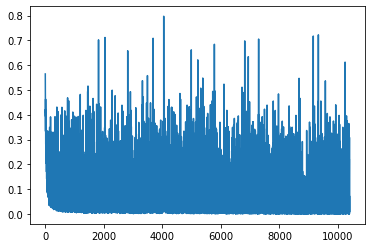

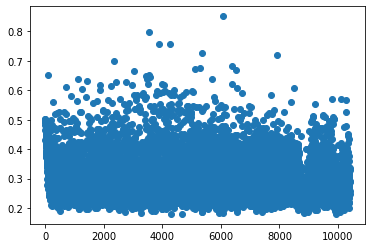

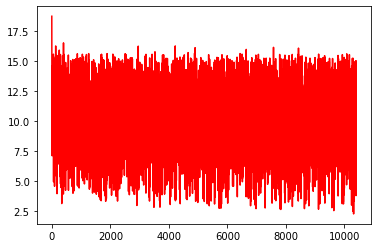

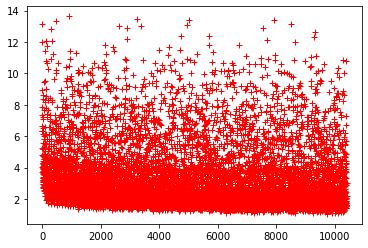

Iteration [10400/15000] | d_real_loss: 0.3061 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.3059 | d_Y_fake_loss: 0.1098 | d_X_fake_loss: 0.1797 |  d_fake_loss: 0.2896 | g_loss_XYX: 2.1674 | g_loss_YXY: 7.8603
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010400-Y-X.png
Iteration [10410/15000] | d_real_loss: 0.3308 | d_Y_real_loss: 0.0013 | d_X_real_loss: 0.3295 | d_Y_fake_loss: 0.1075 | d_X_fake_loss: 0.1212 |  d_fake_loss: 0.2288 | g_loss_XYX: 1.4652 | g_loss_YXY: 7.9360
Iteration [10420/15000] | d_real_loss: 0.2422 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.2421 | d_Y_fake_loss: 0.1093 | d_X_fake_loss: 0.1476 |  d_fake_loss: 0.2569 | g_loss_XYX: 2.5948 | g_loss_YXY: 9.0947
Iteration [10430/15000] | d_real_loss: 0.1435 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.1430 | d_Y_fake_loss: 0.1115 | d_X_fake_loss: 0.3011 |  d_fake_loss: 0.4127 | g_loss_XYX: 1.3361 | g_loss_YXY: 7.4874
Iterat

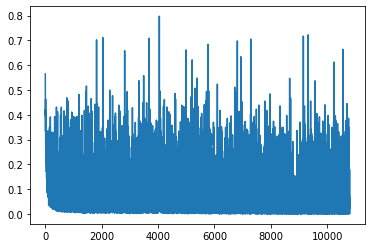

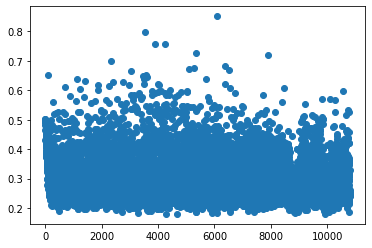

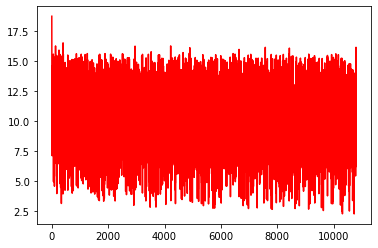

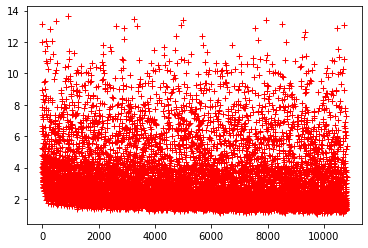

Iteration [10800/15000] | d_real_loss: 0.0064 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0060 | d_Y_fake_loss: 0.1156 | d_X_fake_loss: 0.1380 |  d_fake_loss: 0.2535 | g_loss_XYX: 3.3898 | g_loss_YXY: 6.7604
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-010800-Y-X.png
Iteration [10810/15000] | d_real_loss: 0.0116 | d_Y_real_loss: 0.0012 | d_X_real_loss: 0.0104 | d_Y_fake_loss: 0.1011 | d_X_fake_loss: 0.0889 |  d_fake_loss: 0.1899 | g_loss_XYX: 7.2543 | g_loss_YXY: 6.1120
Iteration [10820/15000] | d_real_loss: 0.0197 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0195 | d_Y_fake_loss: 0.1117 | d_X_fake_loss: 0.1119 |  d_fake_loss: 0.2237 | g_loss_XYX: 1.8373 | g_loss_YXY: 11.5375
Iteration [10830/15000] | d_real_loss: 0.0005 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.0000 | d_Y_fake_loss: 0.1080 | d_X_fake_loss: 0.1676 |  d_fake_loss: 0.2756 | g_loss_XYX: 9.8380 | g_loss_YXY: 5.6892
Itera

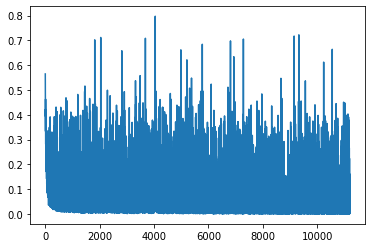

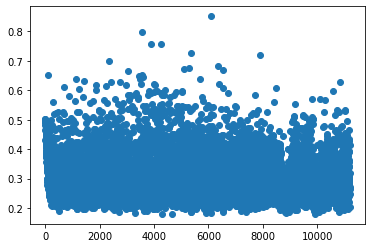

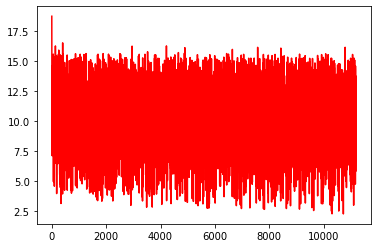

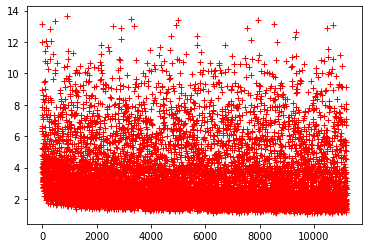

Iteration [11200/15000] | d_real_loss: 0.0341 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0340 | d_Y_fake_loss: 0.1105 | d_X_fake_loss: 0.1593 |  d_fake_loss: 0.2699 | g_loss_XYX: 2.3886 | g_loss_YXY: 7.9553
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-011200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-011200-Y-X.png
Iteration [11210/15000] | d_real_loss: 0.0010 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.0005 | d_Y_fake_loss: 0.1121 | d_X_fake_loss: 0.0817 |  d_fake_loss: 0.1938 | g_loss_XYX: 3.6193 | g_loss_YXY: 6.2555
Iteration [11220/15000] | d_real_loss: 0.0179 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0178 | d_Y_fake_loss: 0.1122 | d_X_fake_loss: 0.1424 |  d_fake_loss: 0.2546 | g_loss_XYX: 4.7661 | g_loss_YXY: 9.8229
Iteration [11230/15000] | d_real_loss: 0.0005 | d_Y_real_loss: 0.0004 | d_X_real_loss: 0.0001 | d_Y_fake_loss: 0.0988 | d_X_fake_loss: 0.1329 |  d_fake_loss: 0.2318 | g_loss_XYX: 10.2593 | g_loss_YXY: 6.2825
Itera

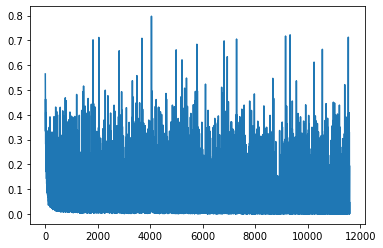

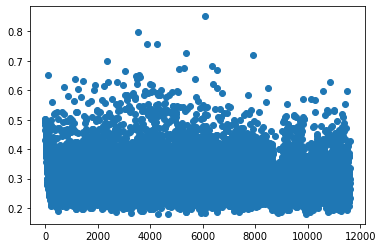

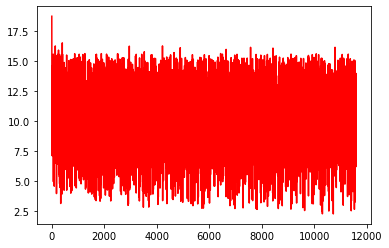

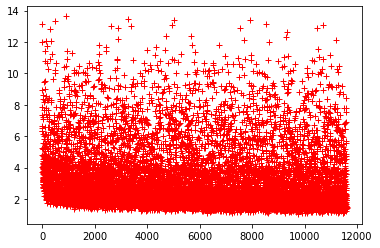

Iteration [11600/15000] | d_real_loss: 0.1921 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1920 | d_Y_fake_loss: 0.1193 | d_X_fake_loss: 0.1654 |  d_fake_loss: 0.2848 | g_loss_XYX: 1.4103 | g_loss_YXY: 10.0546
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-011600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-011600-Y-X.png
Iteration [11610/15000] | d_real_loss: 0.0840 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0839 | d_Y_fake_loss: 0.1183 | d_X_fake_loss: 0.1718 |  d_fake_loss: 0.2901 | g_loss_XYX: 1.7069 | g_loss_YXY: 10.2485
Iteration [11620/15000] | d_real_loss: 0.0006 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0004 | d_Y_fake_loss: 0.1105 | d_X_fake_loss: 0.2471 |  d_fake_loss: 0.3576 | g_loss_XYX: 5.2372 | g_loss_YXY: 8.8025
Iteration [11630/15000] | d_real_loss: 0.2046 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.2045 | d_Y_fake_loss: 0.1187 | d_X_fake_loss: 0.2461 |  d_fake_loss: 0.3648 | g_loss_XYX: 1.5045 | g_loss_YXY: 13.3778
Ite

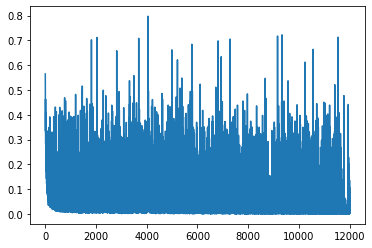

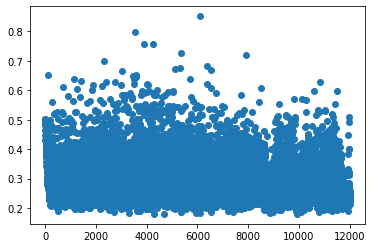

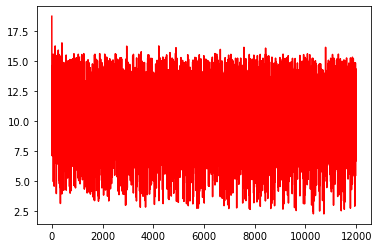

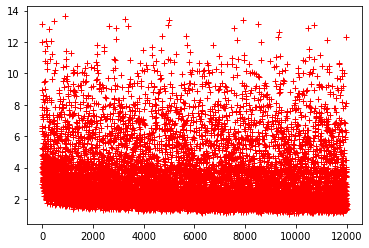

Iteration [12000/15000] | d_real_loss: 0.0053 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0052 | d_Y_fake_loss: 0.1036 | d_X_fake_loss: 0.1088 |  d_fake_loss: 0.2124 | g_loss_XYX: 1.3871 | g_loss_YXY: 6.8645
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012000-Y-X.png
Iteration [12010/15000] | d_real_loss: 0.0283 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0281 | d_Y_fake_loss: 0.1167 | d_X_fake_loss: 0.1177 |  d_fake_loss: 0.2344 | g_loss_XYX: 1.1500 | g_loss_YXY: 9.4369
Iteration [12020/15000] | d_real_loss: 0.0007 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0005 | d_Y_fake_loss: 0.1090 | d_X_fake_loss: 0.1192 |  d_fake_loss: 0.2282 | g_loss_XYX: 7.2211 | g_loss_YXY: 6.9078
Iteration [12030/15000] | d_real_loss: 0.1201 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1200 | d_Y_fake_loss: 0.1192 | d_X_fake_loss: 0.1047 |  d_fake_loss: 0.2239 | g_loss_XYX: 1.6195 | g_loss_YXY: 7.3514
Iterat

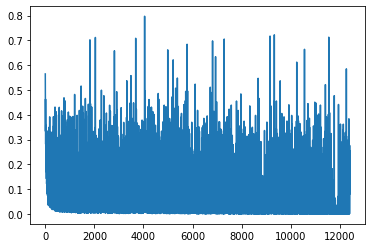

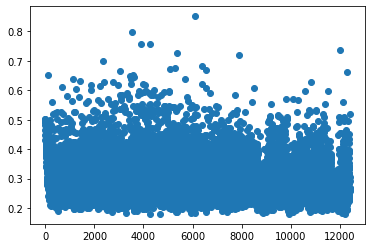

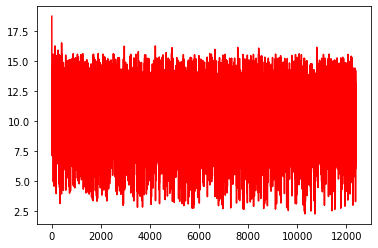

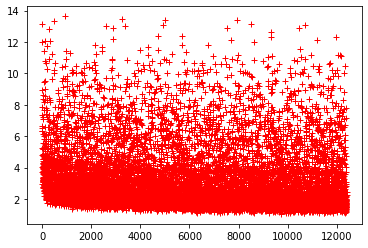

Iteration [12400/15000] | d_real_loss: 0.0803 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0802 | d_Y_fake_loss: 0.1222 | d_X_fake_loss: 0.1461 |  d_fake_loss: 0.2684 | g_loss_XYX: 2.4755 | g_loss_YXY: 10.0493
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012400-Y-X.png
Iteration [12410/15000] | d_real_loss: 0.0007 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0005 | d_Y_fake_loss: 0.1056 | d_X_fake_loss: 0.1490 |  d_fake_loss: 0.2546 | g_loss_XYX: 4.1229 | g_loss_YXY: 7.4123
Iteration [12420/15000] | d_real_loss: 0.2098 | d_Y_real_loss: 0.0005 | d_X_real_loss: 0.2093 | d_Y_fake_loss: 0.1233 | d_X_fake_loss: 0.1424 |  d_fake_loss: 0.2658 | g_loss_XYX: 1.2769 | g_loss_YXY: 4.6250
Iteration [12430/15000] | d_real_loss: 0.1677 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1676 | d_Y_fake_loss: 0.1126 | d_X_fake_loss: 0.2624 |  d_fake_loss: 0.3750 | g_loss_XYX: 1.1619 | g_loss_YXY: 14.0309
Iter

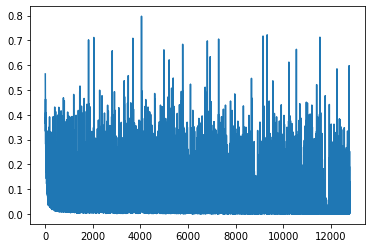

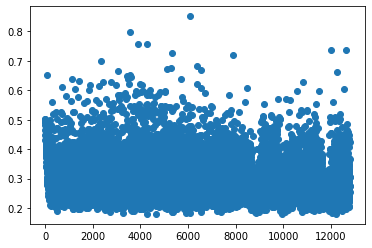

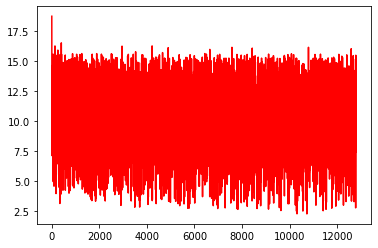

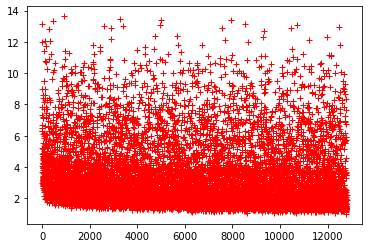

Iteration [12800/15000] | d_real_loss: 0.1239 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1237 | d_Y_fake_loss: 0.1218 | d_X_fake_loss: 0.3031 |  d_fake_loss: 0.4249 | g_loss_XYX: 1.8689 | g_loss_YXY: 9.6033
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-012800-Y-X.png
Iteration [12810/15000] | d_real_loss: 0.1779 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1778 | d_Y_fake_loss: 0.1229 | d_X_fake_loss: 0.3477 |  d_fake_loss: 0.4706 | g_loss_XYX: 1.6479 | g_loss_YXY: 10.9947
Iteration [12820/15000] | d_real_loss: 0.2145 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.2143 | d_Y_fake_loss: 0.1172 | d_X_fake_loss: 0.1864 |  d_fake_loss: 0.3036 | g_loss_XYX: 1.5345 | g_loss_YXY: 9.8970
Iteration [12830/15000] | d_real_loss: 0.0095 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.0089 | d_Y_fake_loss: 0.1158 | d_X_fake_loss: 0.2311 |  d_fake_loss: 0.3469 | g_loss_XYX: 2.8843 | g_loss_YXY: 6.0614
Itera

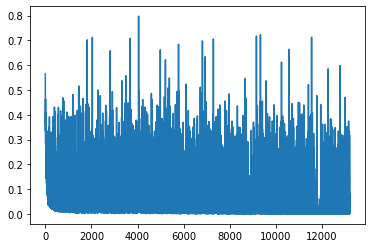

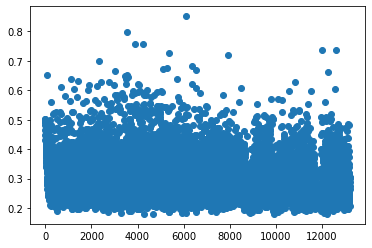

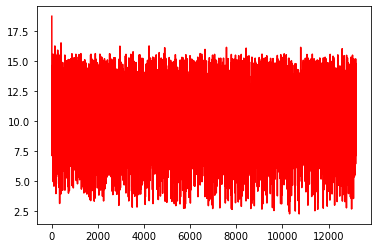

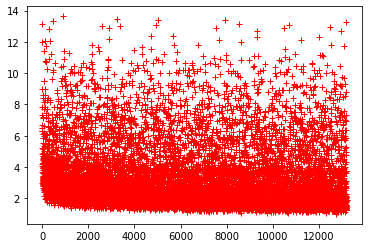

Iteration [13200/15000] | d_real_loss: 0.0823 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.0821 | d_Y_fake_loss: 0.1131 | d_X_fake_loss: 0.1735 |  d_fake_loss: 0.2866 | g_loss_XYX: 1.8708 | g_loss_YXY: 9.8164
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-013200-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-013200-Y-X.png
Iteration [13210/15000] | d_real_loss: 0.1144 | d_Y_real_loss: 0.0006 | d_X_real_loss: 0.1138 | d_Y_fake_loss: 0.1042 | d_X_fake_loss: 0.1214 |  d_fake_loss: 0.2256 | g_loss_XYX: 2.6764 | g_loss_YXY: 6.3712
Iteration [13220/15000] | d_real_loss: 0.0002 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0001 | d_Y_fake_loss: 0.0956 | d_X_fake_loss: 0.2389 |  d_fake_loss: 0.3345 | g_loss_XYX: 8.0243 | g_loss_YXY: 9.9772
Iteration [13230/15000] | d_real_loss: 0.1240 | d_Y_real_loss: 0.0002 | d_X_real_loss: 0.1238 | d_Y_fake_loss: 0.1215 | d_X_fake_loss: 0.1304 |  d_fake_loss: 0.2519 | g_loss_XYX: 1.4410 | g_loss_YXY: 8.1946
Iterat

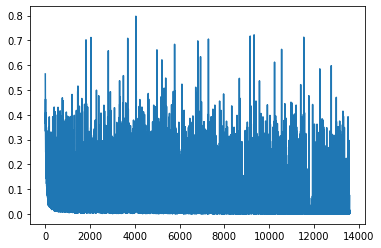

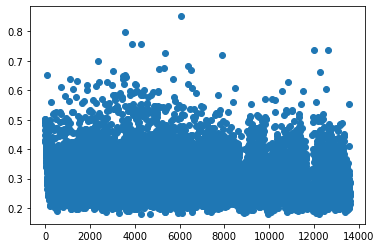

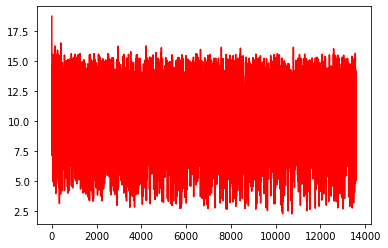

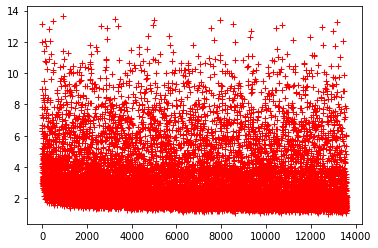

Iteration [13600/15000] | d_real_loss: 0.0072 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0071 | d_Y_fake_loss: 0.1125 | d_X_fake_loss: 0.1373 |  d_fake_loss: 0.2499 | g_loss_XYX: 1.2301 | g_loss_YXY: 13.2142
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-013600-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-013600-Y-X.png
Iteration [13610/15000] | d_real_loss: 0.0010 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0009 | d_Y_fake_loss: 0.1014 | d_X_fake_loss: 0.1158 |  d_fake_loss: 0.2172 | g_loss_XYX: 8.0153 | g_loss_YXY: 7.9847
Iteration [13620/15000] | d_real_loss: 0.0141 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0140 | d_Y_fake_loss: 0.1129 | d_X_fake_loss: 0.1319 |  d_fake_loss: 0.2448 | g_loss_XYX: 1.3251 | g_loss_YXY: 9.1613
Iteration [13630/15000] | d_real_loss: 0.0086 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0085 | d_Y_fake_loss: 0.1068 | d_X_fake_loss: 0.1234 |  d_fake_loss: 0.2303 | g_loss_XYX: 3.2081 | g_loss_YXY: 10.7214
Iter

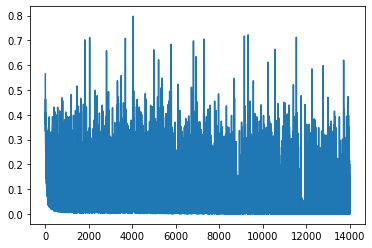

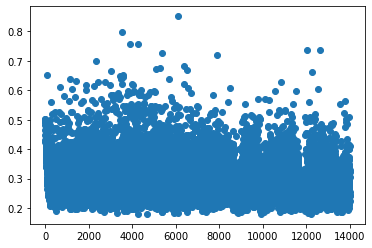

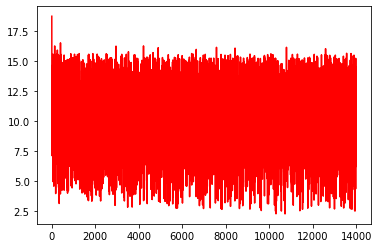

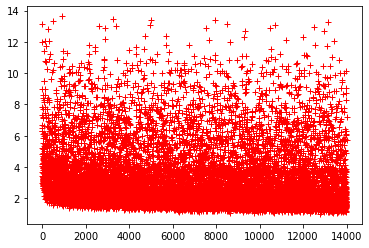

Iteration [14000/15000] | d_real_loss: 0.0003 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0002 | d_Y_fake_loss: 0.1134 | d_X_fake_loss: 0.1394 |  d_fake_loss: 0.2528 | g_loss_XYX: 5.7561 | g_loss_YXY: 12.2000
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014000-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014000-Y-X.png
Iteration [14010/15000] | d_real_loss: 0.0014 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0013 | d_Y_fake_loss: 0.1233 | d_X_fake_loss: 0.3009 |  d_fake_loss: 0.4242 | g_loss_XYX: 2.9208 | g_loss_YXY: 15.1906
Iteration [14020/15000] | d_real_loss: 0.0461 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0461 | d_Y_fake_loss: 0.1161 | d_X_fake_loss: 0.2090 |  d_fake_loss: 0.3251 | g_loss_XYX: 1.2384 | g_loss_YXY: 9.9001
Iteration [14030/15000] | d_real_loss: 0.0002 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0001 | d_Y_fake_loss: 0.0824 | d_X_fake_loss: 0.1780 |  d_fake_loss: 0.2604 | g_loss_XYX: 10.5961 | g_loss_YXY: 10.5087
It

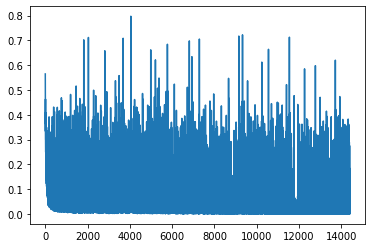

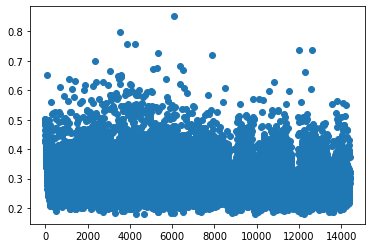

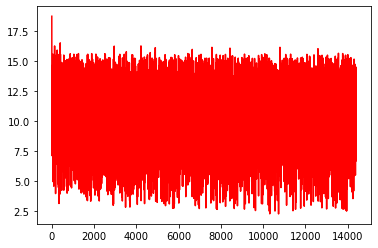

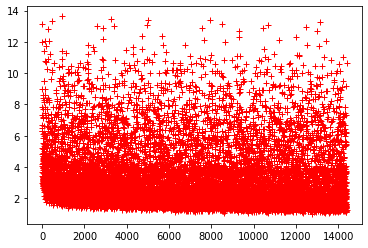

Iteration [14400/15000] | d_real_loss: 0.0001 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0000 | d_Y_fake_loss: 0.1075 | d_X_fake_loss: 0.1782 |  d_fake_loss: 0.2856 | g_loss_XYX: 10.6509 | g_loss_YXY: 9.9484
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014400-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014400-Y-X.png
Iteration [14410/15000] | d_real_loss: 0.1678 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1678 | d_Y_fake_loss: 0.1109 | d_X_fake_loss: 0.1938 |  d_fake_loss: 0.3047 | g_loss_XYX: 1.3562 | g_loss_YXY: 11.2788
Iteration [14420/15000] | d_real_loss: 0.0004 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0000 | d_Y_fake_loss: 0.1403 | d_X_fake_loss: 0.1901 |  d_fake_loss: 0.3304 | g_loss_XYX: 9.7547 | g_loss_YXY: 8.9619
Iteration [14430/15000] | d_real_loss: 0.1002 | d_Y_real_loss: 0.0003 | d_X_real_loss: 0.0999 | d_Y_fake_loss: 0.1136 | d_X_fake_loss: 0.2003 |  d_fake_loss: 0.3139 | g_loss_XYX: 1.7714 | g_loss_YXY: 13.9208
Ite

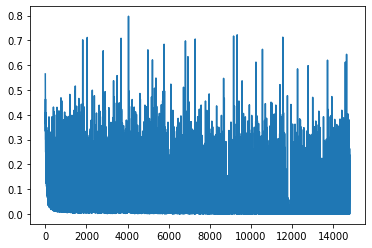

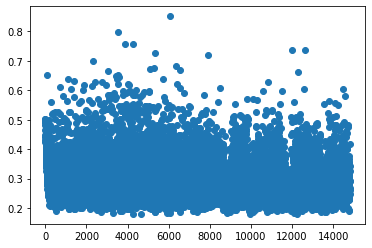

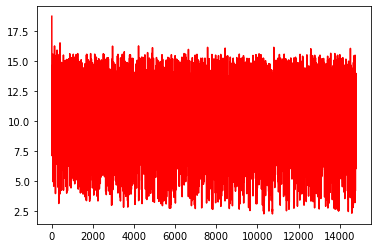

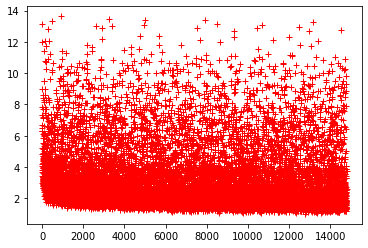

Iteration [14800/15000] | d_real_loss: 0.0013 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0012 | d_Y_fake_loss: 0.1086 | d_X_fake_loss: 0.3090 |  d_fake_loss: 0.4176 | g_loss_XYX: 3.7729 | g_loss_YXY: 9.7763
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014800-X-Y.png
Saved drive/MyDrive/workspace_4471/samples_cyclegan_w_idloss/sample-014800-Y-X.png
Iteration [14810/15000] | d_real_loss: 0.0002 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0002 | d_Y_fake_loss: 0.1177 | d_X_fake_loss: 0.1764 |  d_fake_loss: 0.2941 | g_loss_XYX: 3.4616 | g_loss_YXY: 13.8430
Iteration [14820/15000] | d_real_loss: 0.0363 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.0361 | d_Y_fake_loss: 0.1131 | d_X_fake_loss: 0.1733 |  d_fake_loss: 0.2864 | g_loss_XYX: 2.2430 | g_loss_YXY: 8.9284
Iteration [14830/15000] | d_real_loss: 0.1590 | d_Y_real_loss: 0.0001 | d_X_real_loss: 0.1589 | d_Y_fake_loss: 0.1149 | d_X_fake_loss: 0.1904 |  d_fake_loss: 0.3052 | g_loss_XYX: 1.4807 | g_loss_YXY: 11.9721
Iter

In [ ]:
iter_per_epoch = min(len(iter_X), len(iter_Y))
mse_loss = torch.nn.MSELoss()
L1_loss = torch.nn.L1Loss()

Loss = []

d_real_loss_list = [] 
d_fake_loss_list = [] 
g_loss_YXY_list = []
g_loss_XYX_list = []

for iteration in range(curr_iter+1, opts.train_iters+1):

    # Reset data_iter for each epoch
    if iteration % iter_per_epoch == 0:
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)

    images_X = iter_X.next()[0].to(device)
    images_Y = iter_Y.next()[0].to(device)

    # ============================================
    #            TRAIN THE DISCRIMINATORS
    # ============================================
    
    # Train with real images

    # 1. Compute the discriminator losses on real images
    D_X_real_loss = mse_loss(D_X(images_X), torch.ones(len(images_X)).to(device))
    D_Y_real_loss = mse_loss(D_Y(images_Y), torch.ones(len(images_Y)).to(device))

    d_real_loss = D_X_real_loss + D_Y_real_loss
    d_real_loss_list.append(d_real_loss)
    d_real_loss.backward()
    d_optimizer.step()

    # Train with fake images
    d_optimizer.zero_grad()

    # 2. Generate fake images that look like domain X based on real images in domain Y
    fake_X = G_YtoX(images_Y)

    # 3. Compute the loss for D_X
    D_X_fake_loss = mse_loss(D_X(fake_X), torch.zeros(len(fake_X)).to(device))
    #print(D_X(fake_X))

    # 4. Generate fake images that look like domain Y based on real images in domain X
    fake_Y = G_XtoY(images_X) 

    # 5. Compute the loss for D_Y
    D_Y_fake_loss = mse_loss(D_Y(fake_Y), torch.zeros(len(fake_Y)).to(device))
    #print(D_Y(fake_Y))

    d_fake_loss = D_X_fake_loss + D_Y_fake_loss
    d_fake_loss_list.append(d_fake_loss)
    d_fake_loss.backward()
    d_optimizer.step()

    # =========================================
    #            TRAIN THE GENERATORS
    # =========================================

    g_optimizer.zero_grad()

    # 1. Generate fake images that look like domain X based on real images in domain Y
    fake_X = G_YtoX(images_Y)

    # 2. Compute the generator loss based on domain X
    g_loss_YXY = mse_loss(D_X(fake_X), torch.ones(len(fake_X)).to(device))

    # 3. Compute the cycle consistency loss (the reconstruction loss)
    cycle_consistency_loss = L1_loss(G_XtoY(fake_X), images_Y)
    g_loss_YXY += opts.lbd_cyclegan * cycle_consistency_loss

    # 4. Compute identity loss (Y domain images put into XtoY model should still loook the same)
    identity_loss = L1_loss(G_XtoY(images_Y), images_Y)
    g_loss_YXY += opts.lbd_identity * identity_loss

    g_loss_YXY.backward()
    g_loss_YXY_list.append(g_loss_YXY)
    g_optimizer.step()

    #########################################
    ##           X--Y-->X CYCLE            ##
    #########################################

    g_optimizer.zero_grad()

    # 1. Generate fake images that look like domain Y based on real images in domain X
    fake_Y = G_XtoY(images_X)

    # 2. Compute the generator loss based on domain Y
    g_loss_XYX = mse_loss(D_Y(fake_Y), torch.ones(len(fake_Y)).to(device))

    # 3. Compute the cycle consistency loss (the reconstruction loss)
    cycle_consistency_loss = L1_loss(G_YtoX(fake_Y), images_X)
    g_loss_XYX += opts.lbd_cyclegan * cycle_consistency_loss

    # 4. Compute identity loss (X domain images put into YtoX model should still loook the same)
    identity_loss = L1_loss(G_YtoX(images_X), images_X)
    g_loss_XYX += opts.lbd_identity * identity_loss

    g_loss_XYX.backward()
    g_loss_XYX_list.append(g_loss_XYX)
    g_optimizer.step()

    if iteration % opts.sample_every == 0:

      plt.plot(d_real_loss_list)
      plt.show()
      plt.plot(d_fake_loss_list,'o')
      plt.show()
      plt.plot(g_loss_YXY_list, 'r-')
      plt.show()
      plt.plot(g_loss_XYX_list, 'r+')
      plt.show()

    # Print the log info
    if iteration % opts.log_step == 0:
        print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_Y_real_loss: {:6.4f} | d_X_real_loss: {:6.4f} | d_Y_fake_loss: {:6.4f} | d_X_fake_loss: {:6.4f} |  '
              'd_fake_loss: {:6.4f} | g_loss_XYX: {:6.4f} | g_loss_YXY: {:6.4f}'.format(
                iteration, opts.train_iters, d_real_loss.item(), D_Y_real_loss.item(),
                D_X_real_loss.item(), D_Y_fake_loss.item(),
                D_X_fake_loss.item(), d_fake_loss.item(), g_loss_XYX.item(), g_loss_YXY.item()))

    # Save the generated samples
    if iteration % opts.sample_every == 0:
        save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, opts)

    # Save the model parameters
    if iteration % opts.checkpoint_every == 0:
        checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, g_optimizer, d_optimizer, opts)
        Loss.append({'Iteration': iteration, 
                     'd_real_loss': d_real_loss.item(), 'D_Y_real_loss': D_Y_real_loss.item(), 'D_X_real_loss': D_X_real_loss.item(), 
                     'd_fake_loss': d_fake_loss.item(), 'D_Y_fake_loss': D_Y_fake_loss.item(), 'D_X_fake_loss': D_X_fake_loss.item(),
                     'g_loss_XYX': g_loss_XYX.item(), 'g_loss_YXY': g_loss_YXY.item()})
        losslog_file = os.path.join(opts.losslog_dir, 'losslog')
        with open(losslog_file + ".json", "w") as f:
            json.dump(Loss, f)


#Testing

In [ ]:
ckpt_filepath = "/content/drive/MyDrive/workspace_4471/checkpoints_cyclegan_w_idloss/ckpt_022400.pth.tar"
G_XtoY, G_YtoX, D_X, D_Y = create_model(opts)
load_checkpoint(G_XtoY, G_YtoX, D_X, D_Y, g_optimizer, d_optimizer, curr_iter, ckpt_filepath)

=> loading checkpoint '/content/drive/MyDrive/workspace_4471/checkpoints_cyclegan_w_idloss/ckpt_022400.pth.tar'
=> loaded checkpoint '/content/drive/MyDrive/workspace_4471/checkpoints_cyclegan_w_idloss/ckpt_022400.pth.tar' (iter 22400)


(CycleGenerator_v2(
   (Encoder): Sequential(
     (0): Sequential(
       (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
       (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     )
     (1): ReLU()
     (2): Sequential(
       (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     )
     (3): ReLU()
     (4): Sequential(
       (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     )
     (5): ReLU()
     (6): ResnetBlock(
       (conv_layer): Sequential(
         (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
 

In [ ]:
G_XtoY.to(device)
G_YtoX.to(device)
D_X.to(device)
D_Y.to(device)

test_iter_X = iter(test_dataloader_X)
test_iter_Y = iter(test_dataloader_Y)

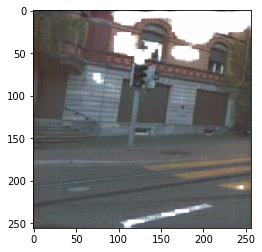

In [ ]:
fixed_X = test_iter_X.next()[0].to(device)
plt.imshow((G_XtoY(fixed_X).cpu().detach().numpy().squeeze().transpose(1,2,0)+1)/2)


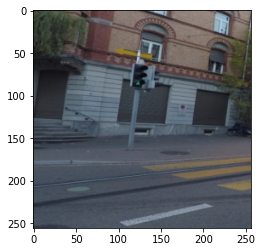

In [ ]:
plt.imshow((fixed_X.cpu().detach().numpy().squeeze().transpose(1,2,0)+1)/2)

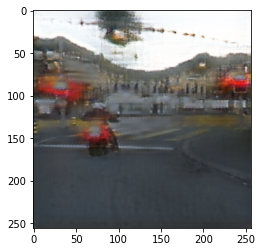

In [ ]:
fixed_Y = test_iter_Y.next()[0].to(device)
plt.imshow((G_YtoX(fixed_Y).cpu().detach().numpy().squeeze().transpose(1,2,0)+1)/2)

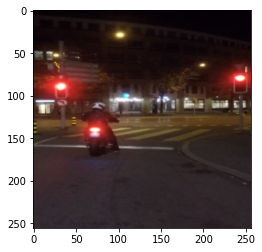

In [ ]:
plt.imshow((fixed_Y.cpu().detach().numpy().squeeze().transpose(1,2,0)+1)/2)